# Compositional and Differential Gene Expression Analysis
---

## Compositional Analysis -  Changes in Immune cells in the Tumor Microenvironement (TME)
---

Single-cell sequencing provides only a small snapshot of the total cells in a tissue or organ, which means we measure relative cell type proportions rather than absolute counts. Because these proportions must always add up to one, an inherent negative correlation is introduced between cell types: an increase in one cell type’s proportion automatically reduces another’s. Traditional statistical methods, like the Wilcoxon test, may misinterpret these shifts as meaningful changes, even when they are artifacts of this proportionality.

scCODA ([Büttner *et al.* 2021]( https://doi.org/10.1038/s41467-021-27150-6)), a Bayesian model adresses these compositional constraints, ensuring that changes in cell-type proportions are analyzed in relation to a reference cell type, thus avoiding false conclusions.

Load packages and data:

In [ ]:
!pip install scanpy sccoda

In [3]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz


In [116]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_2', 'leiden_1', 'leiden_05', 'coarse_celltype_annotation', 'fine_celltype_annotation', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches',

### Distribution of Cell Types - Celltypist Coarse Annotation ('Immune_All_High' model):

See also Notebook *NB2_annotation.ipynb*

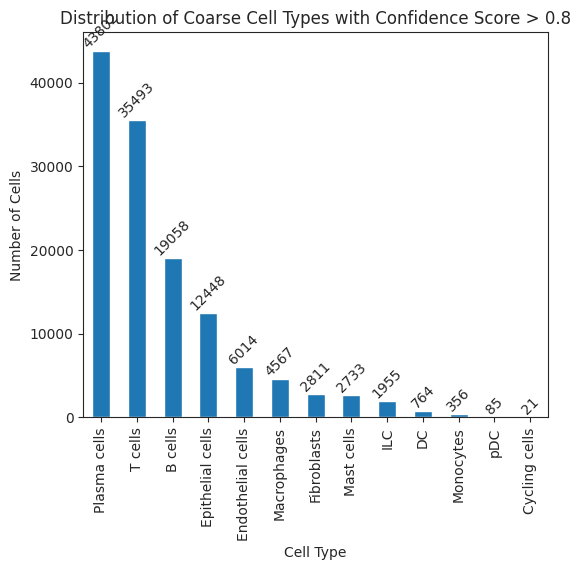

In [5]:
# distribution of predicted cell types - CellTypist coarse
high_conf_coarse = adata.obs[adata.obs['celltypist_conf_score_coarse'] > 0.8]
cell_counts = high_conf_coarse['celltypist_cell_label_coarse'].value_counts()

ax =  cell_counts[cell_counts > 20].sort_values(ascending=False).plot(kind='bar', figsize=(6, 5))
labels = ax.bar_label(ax.containers[0])
for label in labels:
    label.set_rotation(45)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Coarse Cell Types with Confidence Score > 0.8');


### Differences in the Composition of Immune Cells in the Tumor Microenvironment (TME) Depending on Cancer Type and Progression:

The combined datasets encompass three types of gastric adenocarcinoma according to Lauren classification: intestinal, diffuse, and mixed. For the intestinal and diffuse types, both early and advanced samples are available, while for the mixed type, only advanced samples are included.

In [10]:
# list of observed immune cell types
immune_cell_types = ['B cells', 'T cells', 'Plasma cells', 'Mast cells',
                     'DC', 'pDC', 'ILC', 'Monocytes', 'Macrophages',]

# filter the adata.obs DataFrame for high-confidence immune cells
high_conf_coarse_immune = adata.obs[
    (adata.obs['celltypist_conf_score_coarse'] > 0.8) &
    (adata.obs['celltypist_cell_label_coarse'].isin(immune_cell_types))
]


# group by sample_type, lauren_class, phase, and cell type, and count occurrences
immune_cells = high_conf_coarse_immune.groupby(['sample_type',
                                                'lauren_class',
                                                'phase',
                                                'celltypist_cell_label_coarse',
                                                ]).size().reset_index(name='count')


# pivot the table to have cell types as columns
immune_cells_df = immune_cells.pivot_table(index=['sample_type',
                                                  'lauren_class',
                                                  'phase',
                                                  ],
                                  columns='celltypist_cell_label_coarse',
                                  values='count',
                                  fill_value=0)[immune_cell_types]

# reset the index to make the sample_type, lauren_class, and phase columns again
immune_cells_df = immune_cells_df.reset_index()

# modify index
immune_cells_df['type_lauren_phase'] = immune_cells_df.apply(
    lambda row: f"{str(row['sample_type'].replace('primary_', ''))}.{str(row['lauren_class'])}.{str(row['phase'])}", axis=1
)
immune_cells_df.set_index('type_lauren_phase', inplace=True)

# drop rows where all immune cell type counts are zero
immune_cells_df = immune_cells_df.loc[(immune_cells_df[immune_cell_types] != 0).any(axis=1)]



immune_cells_df.head(10)

celltypist_cell_label_coarse,sample_type,lauren_class,phase,B cells,T cells,Plasma cells,Mast cells,DC,pDC,ILC,Monocytes,Macrophages
type_lauren_phase,,,,,,,,,,,,
normal.diffuse.advanced,primary_normal,diffuse,advanced,3597.0,5170.0,10838.0,117.0,82.0,8.0,330.0,56.0,473.0
normal.diffuse.early,primary_normal,diffuse,early,1874.0,3094.0,5640.0,351.0,67.0,1.0,146.0,9.0,281.0
normal.intestinal.advanced,primary_normal,intestinal,advanced,580.0,3211.0,1493.0,170.0,20.0,0.0,118.0,16.0,231.0
normal.intestinal.early,primary_normal,intestinal,early,2949.0,2233.0,6109.0,195.0,63.0,0.0,163.0,7.0,183.0
normal.mixed.advanced,primary_normal,mixed,advanced,131.0,1715.0,721.0,119.0,23.0,0.0,63.0,8.0,95.0
tumor.diffuse.advanced,primary_tumor,diffuse,advanced,3705.0,5893.0,7506.0,189.0,164.0,42.0,406.0,90.0,1514.0
tumor.diffuse.early,primary_tumor,diffuse,early,3558.0,4432.0,4669.0,843.0,103.0,5.0,216.0,11.0,339.0
tumor.intestinal.advanced,primary_tumor,intestinal,advanced,160.0,3470.0,1277.0,160.0,70.0,18.0,213.0,120.0,947.0
tumor.intestinal.early,primary_tumor,intestinal,early,2394.0,3877.0,4440.0,379.0,124.0,8.0,179.0,17.0,324.0


In [11]:
# convert data to anndata object for scCODA
immune_cells = dat.from_pandas(immune_cells_df, covariate_columns=['sample_type',
                                                                   'lauren_class',
                                                                   'phase',
                                                                   ])
immune_cells

AnnData object with n_obs × n_vars = 10 × 9
    obs: 'sample_type', 'lauren_class', 'phase'

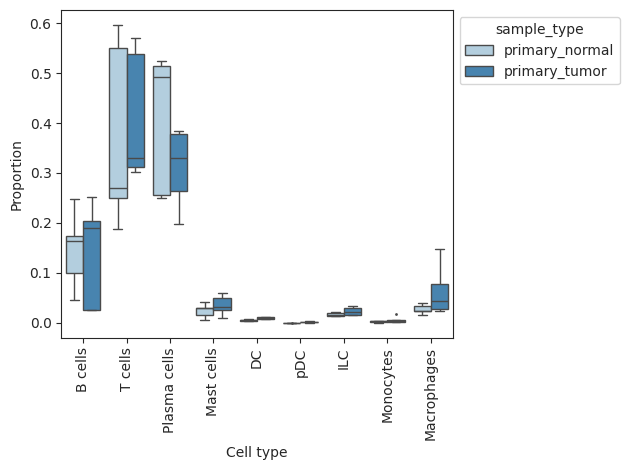

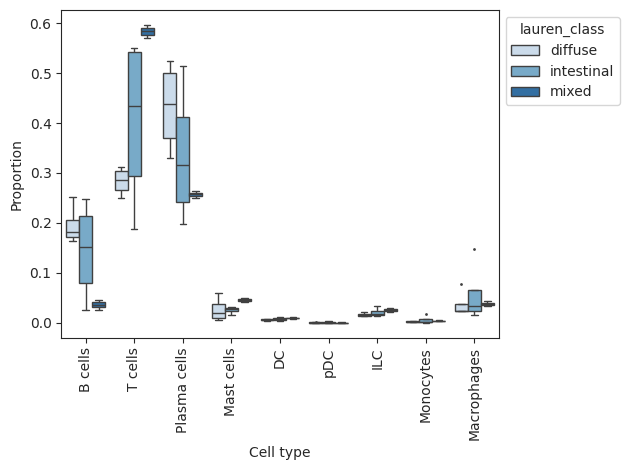

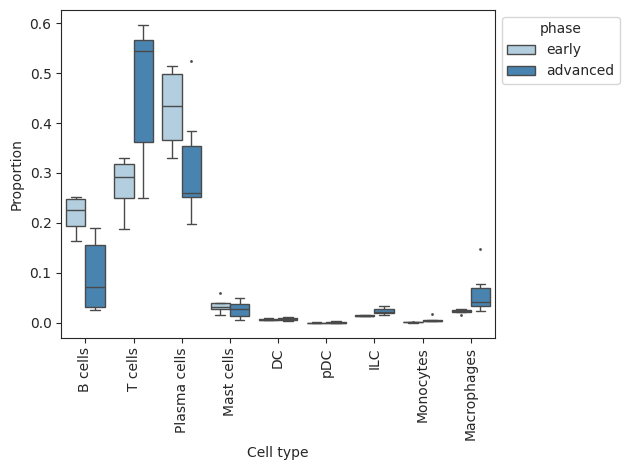

In [12]:
# boxplots - differences in immune cell composition by sample type, Lauren classification, and phase
viz.boxplots(immune_cells, feature_name='sample_type')
viz.boxplots(immune_cells, feature_name='lauren_class')
immune_cells.obs['phase'] = pd.Categorical(immune_cells.obs['phase'], categories=['early', 'advanced'], ordered=True)
viz.boxplots(immune_cells, feature_name='phase');


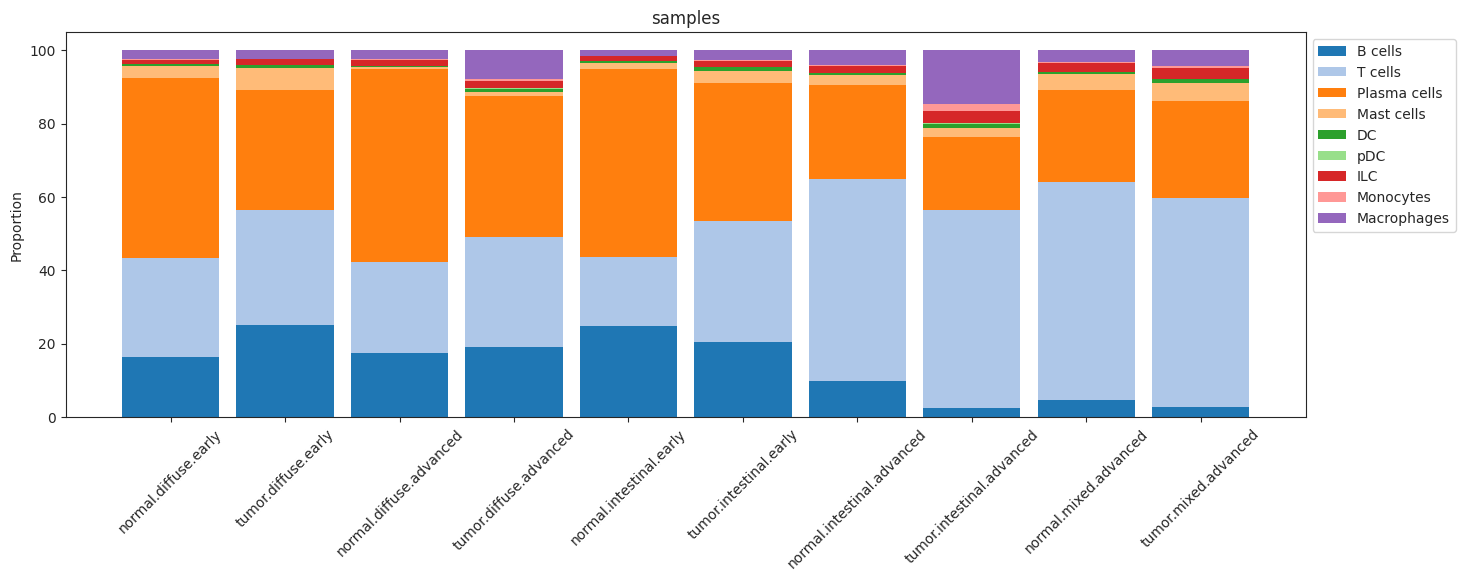

In [13]:
# barplots - differences in immune cell composition for each type of samples
viz.stacked_barplot(immune_cells, feature_name='samples',
                    figsize=(16, 5),
                    level_order=['normal.diffuse.early',
                                 'tumor.diffuse.early',
                                 'normal.diffuse.advanced',
                                 'tumor.diffuse.advanced',
                                 'normal.intestinal.early',
                                 'tumor.intestinal.early',
                                 'normal.intestinal.advanced',
                                 'tumor.intestinal.advanced',
                                 'normal.mixed.advanced',
                                 'tumor.mixed.advanced']);

Using the scCODA model, a Bayesian approach is employed to statistically evaluate changes in cell-type composition, accounting for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions.

 #### Comparison between Lauren's Classes


In [14]:
# advanced - comparison between Lauren's classes
immune_cells_lauren = dat.from_pandas(immune_cells_df[
    (immune_cells_df['phase'] == 'advanced') &
    (immune_cells_df['sample_type'] == 'primary_tumor')],
    covariate_columns=['sample_type', 'lauren_class', 'phase'])
immune_cells_lauren

AnnData object with n_obs × n_vars = 3 × 9
    obs: 'sample_type', 'lauren_class', 'phase'

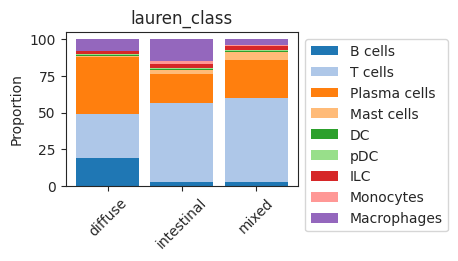

In [15]:
viz.stacked_barplot(immune_cells_lauren, feature_name='lauren_class', figsize=(3,2));

**Changes relative to 'diffuse' class:**

In [39]:
# run model
model_lauren = mod.CompositionalAnalysis(immune_cells_lauren, formula='lauren_class')
lauren_results = model_lauren.sample_hmc()

Automatic reference selection! Reference cell type set to DC


100%|██████████| 20000/20000 [02:31<00:00, 132.10it/s]


MCMC sampling finished. (192.487 sec)
Acceptance rate: 46.6%


In [40]:
# significant changes relative to 'diffuse'
lauren_results.set_fdr(est_fdr=0.1) # set FDR to 0.1
lauren_results.effect_df[lauren_results.effect_df['Final Parameter'] != 0] # filter for significant effects


Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate               Cell Type                                               
lauren_class[T.diffuse] B cells              2.490882   1.909    3.042  0.319   
                        Plasma cells         1.155888   0.789    1.511  0.215   
lauren_class[T.mixed]   Mast cells           0.648341  -0.015    1.299  0.411   
                        Macrophages         -1.114654  -1.706   -0.545  0.380   

                                      Inclusion probability  Expected Sample  \
Covariate               Cell Type                                              
lauren_class[T.diffuse] B cells                    1.000000      1870.665873   
                        Plasma cells               0.994467      3827.837481   
lauren_class[T.mixed]   Mast cells                 0.853467       516.763924   
                        Macrophages                0.957400       485.699629   

                                      log2-fold change  
Covariate               Cell Type                       
lauren_class[T.diffuse] B cells               2.778117  
                        Plasma cells          0.852127  
lauren_class[T.mixed]   Mast cells            1.039000  
                        Macrophages          -1.504465

**Changes relative to 'intestinal' class:**

In [18]:
# set 'intestinal' class as reference
immune_cells_lauren.obs['lauren_class'] = pd.Categorical(immune_cells_lauren.obs['lauren_class'],
                                                  categories=['intestinal', 'diffuse', 'mixed'],
                                                  ordered=True)
# run model
model_lauren2 = mod.CompositionalAnalysis(immune_cells_lauren, formula='lauren_class')
lauren2_results = model_lauren2.sample_hmc()


Automatic reference selection! Reference cell type set to DC


100%|██████████| 20000/20000 [02:21<00:00, 141.58it/s]


MCMC sampling finished. (178.840 sec)
Acceptance rate: 54.3%


In [19]:
# significant changes
lauren2_results.set_fdr(est_fdr=0.1) # set FDR to 0.1
lauren2_results.effect_df[lauren2_results.effect_df['Final Parameter'] != 0] # filter significant effects


Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate               Cell Type                                               
lauren_class[T.diffuse] B cells              2.531651   2.009    3.039  0.278   
                        Plasma cells         1.177512   0.908    1.463  0.159   
lauren_class[T.mixed]   Mast cells           0.673132  -0.049    1.295  0.415   
                        Macrophages         -1.145228  -1.715   -0.605  0.294   

                                      Inclusion probability  Expected Sample  \
Covariate               Cell Type                                              
lauren_class[T.diffuse] B cells                    1.000000      1888.891751   
                        Plasma cells               1.000000      3837.618112   
lauren_class[T.mixed]   Mast cells                 0.817000       513.300131   
                        Macrophages                0.999867       485.655712   

                                      log2-fold change  
Covariate               Cell Type                       
lauren_class[T.diffuse] B cells               2.822838  
                        Plasma cells          0.869229  
lauren_class[T.mixed]   Mast cells            1.080229  
                        Macrophages          -1.543112

A significant increase in B cells (log2 fold change ~2.6) was detected in diffuse-type tumors relative to the mixed and intestinal classes. Plasma cells were also significantly increased in diffuse-type tumors compared to intestinal-type tumors (log2 fold change ~0.8). In contrast, mixed-type tumors showed a significant increase in T cells (log2 fold change ~0.8) and mast cells (log2 fold change ~1.7) relative to diffuse-type tumors, while intestinal-type tumors exhibited a significant increase in macrophages  (log2 fold change ~1.3) compared to mixed-type tumors.

 #### Comparison between Early and Advanced Stages

**Diffuse-type tumors:**

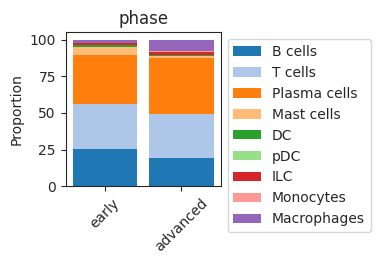

In [20]:
# diffuse - early vs. advanced
immune_cells_diffuse = dat.from_pandas(immune_cells_df[
    (immune_cells_df['lauren_class'] == 'diffuse') &
    (immune_cells_df['sample_type'] == 'primary_tumor')],
    covariate_columns=['sample_type', 'lauren_class', 'phase'])
immune_cells_diffuse.obs['phase'] = pd.Categorical(immune_cells_diffuse.obs['phase'], categories=['early', 'advanced'], ordered=True)
viz.stacked_barplot(immune_cells_diffuse, feature_name='phase', figsize=(2,2));


In [37]:
diffuse_model = mod.CompositionalAnalysis(immune_cells_diffuse, formula='phase')
diffuse_results = diffuse_model.sample_hmc()

Automatic reference selection! Reference cell type set to DC


100%|██████████| 20000/20000 [02:20<00:00, 142.22it/s]


MCMC sampling finished. (176.748 sec)
Acceptance rate: 55.0%


In [38]:
# significant changes
diffuse_results.set_fdr(est_fdr=0.2) # set FDR to 0.2
diffuse_results.effect_df[diffuse_results.effect_df['Final Parameter'] != 0] # filter significant effects


Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate         Cell Type                                              
phase[T.advanced] Mast cells         -1.154635  -2.250    0.209  0.794   
                  Macrophages         0.820764  -0.208    1.629  0.573   

                               Inclusion probability  Expected Sample  \
Covariate         Cell Type                                             
phase[T.advanced] Mast cells                0.826800       222.658892   
                  Macrophages               0.809467      1193.970191   

                               log2-fold change  
Covariate         Cell Type                      
phase[T.advanced] Mast cells          -1.681694  
                  Macrophages          1.168203

**Intestinal-type tumors:**

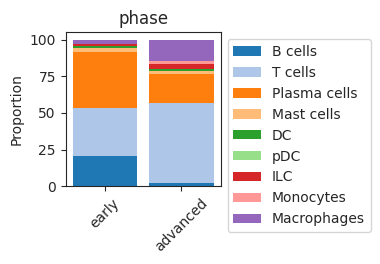

In [34]:
# intestinal - early vs.advanced
immune_cells_intestinal = dat.from_pandas(immune_cells_df[
    (immune_cells_df['lauren_class'] == 'intestinal') &
    (immune_cells_df['sample_type'] == 'primary_tumor')],
    covariate_columns=['sample_type', 'lauren_class', 'phase'])
immune_cells_intestinal.obs['phase'] = pd.Categorical(immune_cells_intestinal.obs['phase'], categories=['early', 'advanced'], ordered=True)
viz.stacked_barplot(immune_cells_intestinal, feature_name='phase', figsize=(2,2));

In [35]:
intestinal_model = mod.CompositionalAnalysis(immune_cells_intestinal, formula='phase')
intestinal_results = intestinal_model.sample_hmc(num_results=30000) # increase num_results i.e. MCMC chain length to increase acceptance rate

Automatic reference selection! Reference cell type set to DC


100%|██████████| 30000/30000 [03:35<00:00, 138.92it/s]


MCMC sampling finished. (252.766 sec)
Acceptance rate: 61.1%


In [36]:
# significant changes
intestinal_results.set_fdr(est_fdr=0.2) # set FDR to 0.2
intestinal_results.effect_df[intestinal_results.effect_df['Final Parameter'] != 0] # filter significant effects

Final Parameter  HDI 3%  HDI 97%     SD  \
Covariate         Cell Type                                               
phase[T.advanced] B cells             -2.097855  -3.407   -0.621  0.825   
                  Plasma cells        -0.993977  -1.652    0.035  0.534   
                  Monocytes            1.099091  -0.672    2.698  0.938   
                  Macrophages          1.194572  -0.038    2.359  0.691   

                                Inclusion probability  Expected Sample  \
Covariate         Cell Type                                              
phase[T.advanced] B cells                     0.96224       300.889272   
                  Plasma cells                0.85632      1809.163953   
                  Monocytes                   0.64008       175.684243   
                  Macrophages                 0.87216      1492.441419   

                                log2-fold change  
Covariate         Cell Type                       
phase[T.advanced] B cells              -2.492415  
                  Plasma cells         -0.899856  
                  Monocytes             2.119803  
                  Macrophages           2.257552

For both diffuse- and intestinal-type tumors, a significant increase in macrophages in the TME was observed in advanced compared to early stages. In intestinal-type tumors, there was also an increase in monocytes, but a decrease in B cells and plasma cells in advanced stages. In contrast, diffuse-type tumors showed a decrease in mast cells in advanced stages.

However, there are a few limitations of scCODA to be aware of:

scCODA assumes that the relationship between covariates and cell abundance follows a log-linear pattern. That is, it assumes that as covariates change, the abundance of cell types changes in a predictable, proportional way. However, in biological systems, the relationship between covariates and cell abundances might not always behave in such a straightforward, linear manner.

Additionally, scCODA focuses on identifying changes in the average abundance of cell types, meaning it detects if a particular cell type is generally more or less abundant across conditions. But it doesn't capture whether there is increased variability in the response (e.g., if the cell type abundance fluctuates more in one condition than another).

## Differential Gene Expression Analysis
---


There are two main approaches to differential expression analysis in single-cell data. The first is the sample-level view, where expression data is aggregated into "pseudobulks" and analyzed using methods originally developed for bulk RNA-seq, such as edgeR ([Robinson *et al.* 2010](https://doi.org/10.1093/bioinformatics/btp616)). The second is the cell-level (or single-cell specific) approach, such as scVI's model.differential_expression() ([Gayoso *et al.* 2022](http://doi.org/10.1038/s41587-021-01206-w)), which uses a Bayesian variational autoencoder to model gene expression at the single-cell level, accounting for cell-to-cell variability and technical noise.

Load packages and data:

In [ ]:
!pip install scanpy scvi-tools
!R -e "install.packages('BiocManager', repos='http://cran.rstudio.com/')"
!R -e "BiocManager::install('edgeR')"

In [2]:
import gc

import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()
pd.DataFrame.iteritems = pd.DataFrame.items # avoid error in newer pandas versions (AttributeError: 'DataFrame' object has no attribute 'iteritems')


In [4]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_2', 'leiden_1', 'leiden_05', 'coarse_celltype_annotation', 'fine_celltype_annotation', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches',

### Pseudobulk method

The pseudobulk method for differential gene expression aggregates expression data from individual cells by sample or condition, creating bulk-like profiles that are then analyzed using bulk RNA-seq tools such as edgeR ([Robinson *et al.* 2010](https://doi.org/10.1093/bioinformatics/btp616)). This approach reduces technical noise and variability inherent to single-cell data, making it more robust in some cases compared to methods designed specifically for scRNA-seq.

#### Prepare Data for edgeR Analysis

Get pseudobulks:

In [4]:
# set .X to raw counts
adata.X = adata.layers['counts']

In [5]:
# add new combined column (to use as key to identify samples)
adata.obs['patient_sample'] = adata.obs.apply(
    lambda row: f"{str(row['patient'])}-{str(row['sample_type'].replace('primary_', ''))}", axis=1)

# add simplified and cleaned up 'celltype' column
adata.obs['celltype'] = adata.obs['fine_celltype_annotation'].str.replace(' ', '_')
adata.obs.loc[adata.obs['celltype'].str.contains('mucous', case=False), 'celltype'] = 'Mucous_cells'
adata.obs['celltype'] = adata.obs['celltype']

# add 'group' column (to group replicates)
adata.obs['group'] = adata.obs.apply(
    lambda row: f"{str(row['celltype'])}_{str(row['lauren_class'])}_{str(row['phase'])}_{str(row['sample_type'].replace('primary_', ''))}", axis=1)

# add 'comparison_group' column (for which to compare tumor to normal)
adata.obs['comparison_group'] = adata.obs.apply(
    lambda row: f"{str(row['celltype'])}_{str(row['lauren_class'])}_{str(row['phase'])}", axis=1)

In [6]:
def get_pseudobulk(celltypes, sample_key, obs_to_keep, n_cells_cutoff=4):
    """
    Create a pseudobulk AnnData object by aggregating gene counts per celltype and sample.

    Args:
        celltypes (list of str): List of celltypes for which to create pseudobulks.
        sample_key (str): Key in `obs` used to identify samples.
        obs_to_keep (list of str): Observation columns to retain in the output.
        n_cells_cutoff (int, optional): Minimum number of cells per sample to include (default is 4).
          Patients are excluded if any of their samples have fewer than this number of cells or if the sample is missing.

    Returns:
        anndata.AnnData: Pseudobulked AnnData object with aggregated counts.
    """

    df = None

    for celltype in celltypes:
        # subset adata to the given celltype
        adata_celltype = adata[adata.obs['celltype'] == celltype].copy()

        # drop patients with missing or insufficient cell counts for any sample type
        all_patients = adata_celltype.obs['patient'].unique()
        size_by_sample = adata_celltype.obs.groupby(sample_key, observed=False).size()

        patients_to_drop = []
        for patient in all_patients:
            patient_samples = size_by_sample[size_by_sample.index.str.startswith(patient)]
            if len(patient_samples) < 2 or any(patient_samples < n_cells_cutoff):  # Ensure both normal and tumor samples exist and meet cutoff
                patients_to_drop.append(patient)

        patients_to_drop = sorted(list(set(patients_to_drop)))
        print(celltype, ':')
        print('Number of excluded patients due to low cell number or missing samples:', len(patients_to_drop))
        print('Excluded patients due to low cell number or missing samples:', patients_to_drop)


        adata_celltype = adata_celltype[~adata_celltype.obs['patient'].isin(patients_to_drop)]

        # create a DataFrame with all genes and observation info
        df_celltype = pd.DataFrame(adata_celltype.X.toarray(),
                                   index=adata_celltype.obs_names,
                                   columns=adata_celltype.var_names)
        df_celltype = adata_celltype.obs[obs_to_keep].join(df_celltype)
        df_celltype = df_celltype.astype({col: 'category' for col in obs_to_keep})

        # aggregate gene counts per patient for the specific celltype
        agg_dict = {col: 'first' for col in obs_to_keep}
        agg_dict.update({gene: 'sum' for gene in adata_celltype.var_names})
        df_celltype = df_celltype.groupby(sample_key, as_index=False, observed=True).agg(agg_dict)

        # append dataframes
        if df is None:
            df = df_celltype.copy()
        else:
            df = pd.concat([df, df_celltype], ignore_index=True)
        df.index = df.index.astype(str)
        df[obs_to_keep] = df[obs_to_keep].astype('category')

    # create AnnData object from the DataFrame
    adata_pseudobulk = sc.AnnData(df[adata.var_names], obs=df.drop(columns=adata.var_names))

    # create edgeR input 1 - counts DataFrame
    counts_df = pd.DataFrame(adata_pseudobulk.X.T)
    counts_df.insert(0, 'genes', adata_pseudobulk.var_names)

    # create edgeR input 2 - group info DataFrame
    group_info = adata_pseudobulk.obs[obs_to_keep]

    return adata_pseudobulk, counts_df, group_info


In [7]:
# get pseudobulk count dataframe and anndata object for fibroblasts and mucous cells
adata_pseudobulk, counts_df, group_info = get_pseudobulk(celltypes=['Fibroblasts', 'Mucous_cells'],
                                          sample_key='patient_sample',
                                          obs_to_keep=['patient_sample', 'comparison_group', 'celltype', 'group', 'lauren_class', 'phase', 'sample_type', 'sex', 'patient', 'dataset'])
adata_pseudobulk

Fibroblasts :
Number of excluded patients due to low cell number or missing samples: 6
Excluded patients due to low cell number or missing samples: ['NGCII513', 'kim_patient_1', 'kim_patient_19', 'kim_patient_2', 'kim_patient_20', 'kim_patient_23']
Mucous_cells :
Number of excluded patients due to low cell number or missing samples: 1
Excluded patients due to low cell number or missing samples: ['NGCII513']


AnnData object with n_obs × n_vars = 110 × 26809
    obs: 'patient_sample', 'comparison_group', 'celltype', 'group', 'lauren_class', 'phase', 'sample_type', 'sex', 'patient', 'dataset'

In [8]:
# number of replicates (i.e. patients) per cancer-phase-tissue group for each celltype
adata_pseudobulk.obs.groupby(['celltype', 'group'], observed=True).size()

celltype      group                                  
Fibroblasts   Fibroblasts_diffuse_advanced_normal         7
              Fibroblasts_diffuse_advanced_tumor          7
              Fibroblasts_diffuse_early_normal            7
              Fibroblasts_diffuse_early_tumor             7
              Fibroblasts_intestinal_advanced_normal      3
              Fibroblasts_intestinal_advanced_tumor       3
              Fibroblasts_intestinal_early_normal         6
              Fibroblasts_intestinal_early_tumor          6
              Fibroblasts_mixed_advanced_normal           2
              Fibroblasts_mixed_advanced_tumor            2
Mucous_cells  Mucous_cells_diffuse_advanced_normal       10
              Mucous_cells_diffuse_advanced_tumor        10
              Mucous_cells_diffuse_early_normal           7
              Mucous_cells_diffuse_early_tumor            7
              Mucous_cells_intestinal_advanced_normal     3
              Mucous_cells_intestinal_advanced_tumor      3
              Mucous_cells_intestinal_early_normal        8
              Mucous_cells_intestinal_early_tumor         8
              Mucous_cells_mixed_advanced_normal          2
              Mucous_cells_mixed_advanced_tumor           2
dtype: int64

In [9]:
gc.collect()

29425

Principal component analysis (PCA) to check for outliers and confounding factors:

In [71]:
# set X to raw counts
adata_pseudobulk.layers['counts'] = adata_pseudobulk.X.copy()

In [72]:
# normalize cunts and calculate PCA
sc.pp.normalize_total(adata_pseudobulk, target_sum=1e6)
sc.pp.log1p(adata_pseudobulk)
sc.pp.pca(adata_pseudobulk)

In [73]:
# add library size columns to check if library size confounding factor
adata_pseudobulk.obs['lib_size'] = np.sum(adata_pseudobulk.layers['counts'], axis=1)
adata_pseudobulk.obs['log_lib_size'] = np.log(adata_pseudobulk.obs['lib_size'])

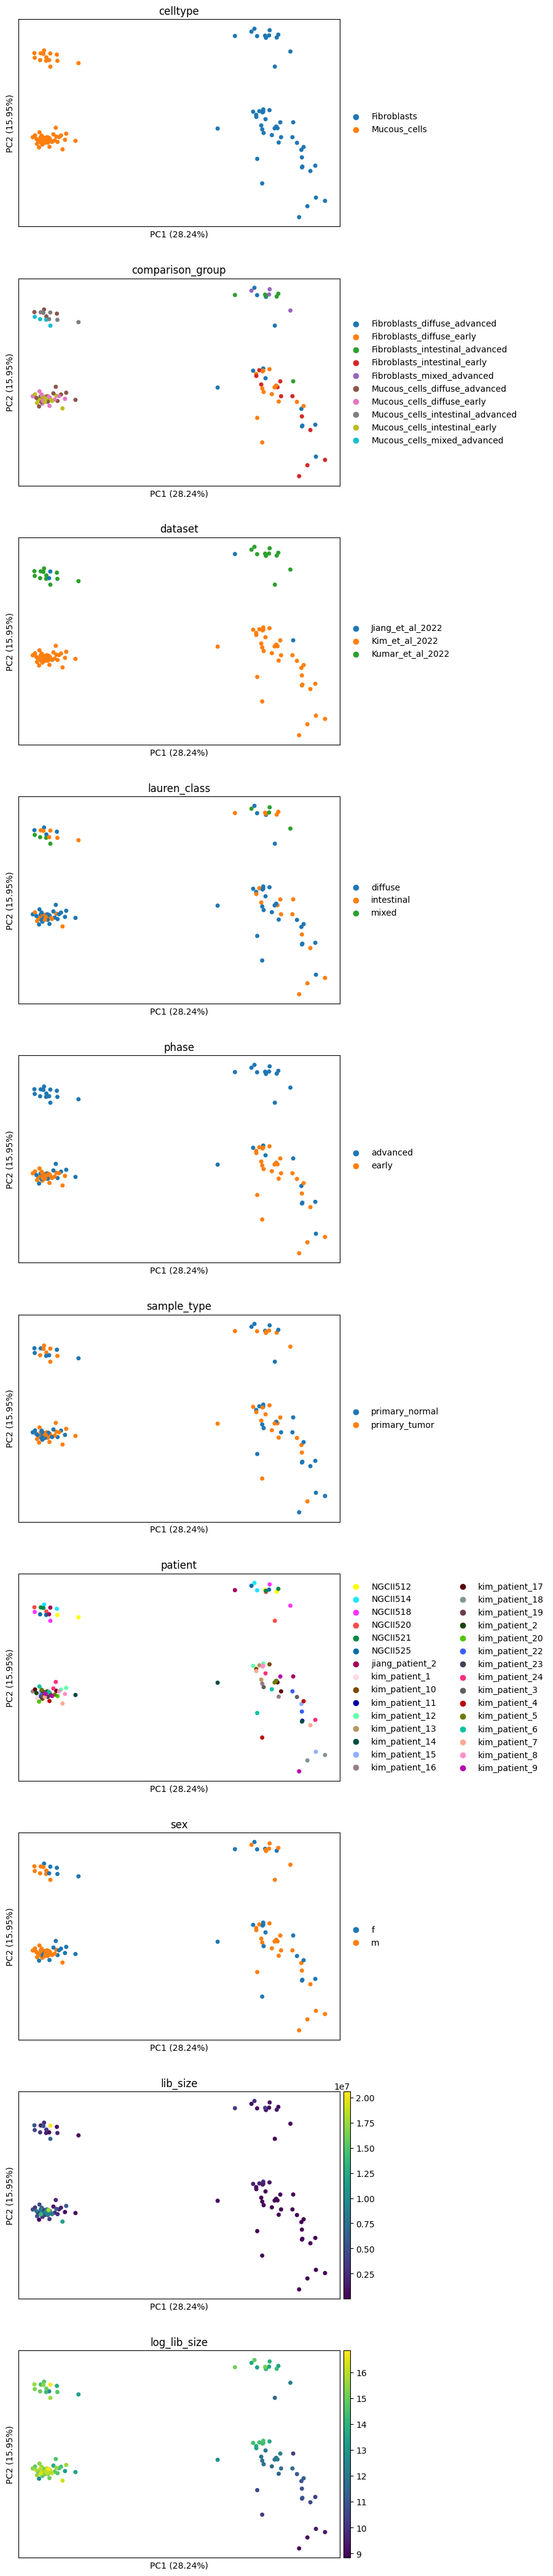

In [74]:
sc.pl.pca(adata_pseudobulk, color=['celltype', 'comparison_group', 'dataset', 'lauren_class', 'phase', 'sample_type', 'patient', 'sex', 'lib_size', 'log_lib_size'], annotate_var_explained=True, ncols=1, size=100)

PC1 primarily separates the different celltypes, while PC2 distinguishes the Kim dataset from the other two datasets. The separation observed in PC2 is expected, as the raw counts have not undergone batch integration. Consequently, this dataset-specific variation should be accounted for as a covariate in the gene expression analysis to control for potential batch effects.




In [75]:
# clear memory (if needed)
gc.collect()

37236

#### Perfom Differential Expression Analysis (DEA) with edgeR

In [153]:
%load_ext rpy2.ipython

Function to Create the Design Matrix and Fit a Quasi-Likelihood Generalized Linear Model (GLM) Using edgeR:

In [ ]:
%%R
library(edgeR)

# Function to fit an edgeR model with any number of covariates
# Args:
#   counts_df: DataFrame containing count data. Genes should be in rows and samples in columns.
#   group_info: DataFrame containing sample annotations (e.g., group, batch information).
#   group: Column name in group_info that represents the experimental group.
#   covariates: Optional vector of column names in group_info representing covariates (e.g., batch, dataset).
# Returns:
#   A list containing the fitted model ('fit'), design matrix ('design'), and the DGEList ('dge').

fit_model <- function(counts_df, group_info, group='group', covariates=NULL) {

    # create DGEList
    dge <- DGEList(counts = counts_df[,2:ncol(counts_df)], group=group_info[[group]])

    # add genes to DGEList
    dge$genes <- data.frame(gene_symbol=counts_df[,1])

    # filter low-count genes
    dge_keep <- filterByExpr(dge)
    dge <- dge[dge_keep, keep.lib.sizes=FALSE]

    # Calculate normalization factors
    dge <- calcNormFactors(dge) # default TMM

    # get design matrix
    design_formula <- paste('~ 0 +', group)

    if (!is.null(covariates)) {
        for (covariate in covariates) {
            design_formula <- paste(design_formula, '+', covariate)
        }
    }
    design_dge <- model.matrix(as.formula(design_formula), data = group_info)
    colnames(design_dge) <- gsub('group|dataset', '', colnames(design_dge))
    colnames(design_dge) <- gsub('_+', '_', colnames(design_dge))

    # estimate dispersion
    dge <- estimateDisp(dge, design_dge)

    # fit the model
    dge_fit <- glmQLFit(dge, design_dge)

    return(list('fit' = dge_fit, 'design' = design_dge, 'dge' = dge))
}


Fit model to data:

In [13]:
%%R -i counts_df -i group_info
outs <- fit_model(counts_df, group_info, group='group', covariates='dataset')
dge = outs$dge
fit = outs$fit
design = outs$design

Since tumor and normal samples were paired from the same patient, 'Patient' was initially considered as a covariate. However, 'Patient' was dropped due to high collinearity and redundancy with other variables, which would have affected the model's ability to estimate unique coefficients.

PCA on unfitted normalized data similar to PCA results using scanpy (see above):

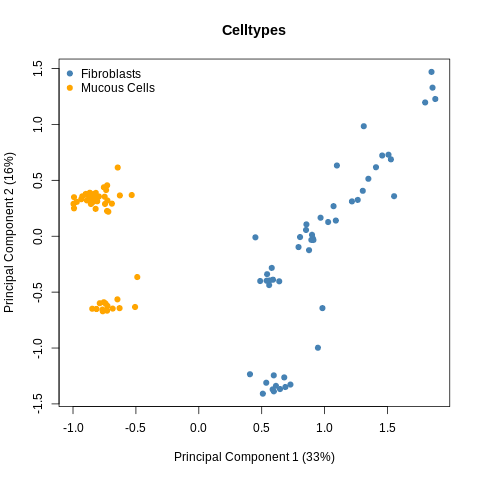

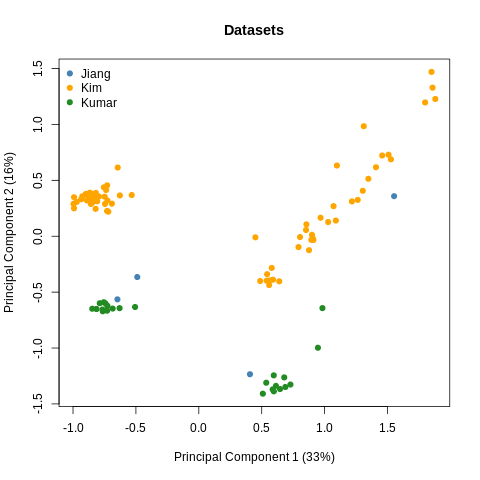

In [14]:
%%R
# plot PCA with celltypes color-coded
plotMDS(dge, gene.selection='common', col=ifelse(grepl('Fibroblasts', dge$samples$group), 'steelblue', 'orange'),
         pch=19, var.explained=TRUE, top=Inf, main='Celltypes') # set gene.selection='common' for PCA
legend('topleft', legend = c('Fibroblasts', 'Mucous Cells'),
       col = c('steelblue', 'orange'), pch = 19, bty = 'n')


# plot PCA with datasets color-coded
dataset <- factor(group_info$dataset)
plotMDS(dge, gene.selection='common', col=c('steelblue', 'orange', 'forestgreen')[dataset],
        pch=19, var.explained=TRUE, top=Inf, main='Datasets') # set gene.selection='common' for PCA
legend('topleft', legend = c('Jiang', 'Kim', 'Kumar'),
       col = c('steelblue', 'orange', 'forestgreen'), pch = 19, bty = 'n')

Biological Coefficient of Variation (BCV) plot:

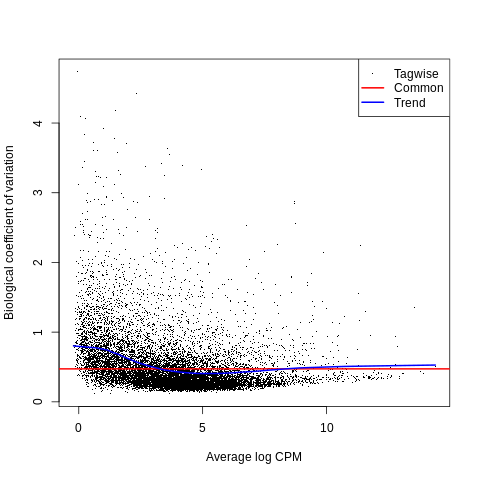

In [80]:
%%R
plotBCV(dge)

Get differentially expressed genes between tumor and normal samples:

In [15]:
%%R -i group_info -o de_tumor_vs_normal

# get differnetial expression (DE) results for each comparison group

de_tumor_vs_normal <- list()

for (comparison_group in unique(group_info$comparison_group)) {

    print(comparison_group)

    # create contrast
    contrast <- makeContrasts(paste0(comparison_group, '_tumor', '-', comparison_group, '_normal'), levels = design)

    # perform QLF test

    qlf <- glmQLFTest(fit, contrast=contrast)

    # get results
    deg <- topTags(qlf, n = Inf)

    # save in list
    de_tumor_vs_normal[[comparison_group]] <- deg$table

}


[1] "Fibroblasts_intestinal_advanced"
[1] "Fibroblasts_diffuse_advanced"
[1] "Fibroblasts_mixed_advanced"
[1] "Fibroblasts_diffuse_early"
[1] "Fibroblasts_intestinal_early"
[1] "Mucous_cells_intestinal_advanced"
[1] "Mucous_cells_diffuse_advanced"
[1] "Mucous_cells_mixed_advanced"
[1] "Mucous_cells_intestinal_early"
[1] "Mucous_cells_diffuse_early"


#### Differentially Expressed Genes (DEGs) between Tumor and Normal Samples - edgeR

TOP10 DEGs per celltype - laurens class - phase group:

In [16]:
# TOP10 DEGs (ranked by FDR)
for comparison_group, df in de_tumor_vs_normal.items():
    print(f"\nComparison group: {comparison_group}")
    display(df.head(10))


Comparison group: Fibroblasts_intestinal_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
12174,GREM1,5.441429,4.763940,25.456268,0.000001,0.014462
12835,HOXA7,-9.030366,1.769986,25.029041,0.000002,0.014462
18438,P4HA3,4.414534,1.792061,23.216340,0.000004,0.019887
21717,SFRP2,11.506598,6.157029,21.837881,0.000010,0.033984
8277,CHRDL2,5.820810,2.914147,20.935877,0.000011,0.033984
22477,SMOC1,5.327703,3.410459,19.167952,0.000022,0.060448
11815,GJB2,8.518558,4.206664,19.125377,0.000030,0.068103
8674,COL8A1,3.504659,4.087189,18.450610,0.000034,0.068103
13297,IGKV2-30,9.565368,4.973772,26.407837,0.000039,0.069191
6168,ASPN,3.470051,5.805936,17.917704,0.000046,0.073328



Comparison group: Fibroblasts_diffuse_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
9127,CXCL6,4.406787,5.136158,39.557770,4.539653e-09,0.000073
16762,MMP1,4.947670,8.636683,35.473542,4.163502e-08,0.000250
9126,CXCL5,9.059259,7.129664,35.649951,4.645767e-08,0.000250
9125,CXCL3,4.431642,8.820562,30.807259,2.187128e-07,0.000883
8949,CSF2,11.020031,2.706327,30.004336,2.920708e-07,0.000943
13530,INHBA,5.844120,5.582574,29.481916,3.787853e-07,0.001020
7655,CCL20,5.407908,7.457376,28.133299,5.610305e-07,0.001294
10972,FAP,4.099048,3.162338,27.109956,7.659723e-07,0.001546
13406,IL11,4.443238,3.342742,25.446504,1.284051e-06,0.002304
12745,HMGA1,2.885049,7.598354,25.387123,1.648093e-06,0.002481



Comparison group: Fibroblasts_mixed_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
16787,MMP9,11.355646,1.937968,27.207153,6.624588e-07,0.010699
8673,COL7A1,5.002250,4.535770,19.943185,1.610509e-05,0.130057
5454,ANXA3,-8.018521,6.461359,17.081857,6.604806e-05,0.355581
25095,UBD,5.743837,5.073382,15.422786,1.489157e-04,0.511082
6976,C1QTNF3,-5.284590,2.524645,14.706145,1.875900e-04,0.511082
7272,CADM3,-8.770128,1.080487,15.410526,2.044911e-04,0.511082
7897,CDH19,-9.846676,1.626270,15.018490,2.364934e-04,0.511082
3711,ADPRHL1,-7.725841,1.774108,14.426095,2.531518e-04,0.511082
19312,PLP1,-9.968777,1.583723,14.158737,4.475383e-04,0.710464
22000,SLC1A3,5.606120,1.532354,12.680628,5.259167e-04,0.710464



Comparison group: Fibroblasts_diffuse_early


,gene_symbol,logFC,logCPM,F,PValue,FDR
13140,IGF1,3.592603,4.574504,38.831272,4.136544e-09,0.000067
19035,PI16,9.616586,1.256912,36.349714,1.769318e-08,0.000143
21717,SFRP2,5.533102,6.157029,33.206568,1.056249e-07,0.000569
20016,PSTPIP1,4.371102,2.717572,23.670934,3.405113e-06,0.012611
8277,CHRDL2,4.533939,2.914147,23.145400,3.903938e-06,0.012611
6976,C1QTNF3,2.724750,2.524645,20.700889,1.134905e-05,0.030550
18438,P4HA3,4.577192,1.792061,19.172444,2.311466e-05,0.039770
21164,RSPO3,3.559012,2.220110,20.100205,2.418088e-05,0.039770
12060,GPNMB,2.529681,3.951213,19.165181,2.425366e-05,0.039770
8674,COL8A1,2.715490,4.087189,19.137570,2.462412e-05,0.039770



Comparison group: Fibroblasts_intestinal_early


,gene_symbol,logFC,logCPM,F,PValue,FDR
21717,SFRP2,13.264982,6.157029,32.820222,1.223246e-07,0.001976
14271,KPNA2,2.748431,6.010784,19.397667,2.501513e-05,0.175738
8277,CHRDL2,3.969982,2.914147,17.969901,4.096938e-05,0.175738
18711,PCLAF,4.033732,6.522715,18.040215,4.352380e-05,0.175738
8982,CST1,6.643701,5.365361,17.962225,5.603434e-05,0.181002
24022,TMEM158,3.103578,3.868495,16.662490,7.564675e-05,0.197719
10154,EGLN3,2.614563,4.727853,16.549563,8.569312e-05,0.197719
8985,CST4,11.832183,3.329043,17.053089,1.320601e-04,0.212342
21718,SFRP4,9.338043,3.070474,16.222890,1.345393e-04,0.212342
8633,COL13A1,-2.989867,2.914153,15.404600,1.481490e-04,0.212342



Comparison group: Mucous_cells_intestinal_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
8188,CGA,11.410583,2.352343,24.432108,0.000004,0.041442
13732,ITIH5,-5.220323,3.448286,22.313091,0.000005,0.041442
20871,RNF152,-4.222860,3.137749,21.755333,0.000008,0.041442
5205,ALB,-8.911042,1.624731,21.344971,0.000014,0.054866
17281,MYO1F,-3.062302,1.820112,19.113031,0.000026,0.083183
25930,ZAP70,-3.211286,1.609154,18.334542,0.000035,0.089541
6161,ASPA,-4.153518,2.151423,17.707053,0.000045,0.089541
10315,EML1,-4.026586,3.454265,17.575855,0.000046,0.089541
20785,RIOX2,2.339576,4.199222,17.798279,0.000050,0.089541
14390,LAMA5,3.653073,4.416656,17.450309,0.000060,0.092606



Comparison group: Mucous_cells_diffuse_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
21250,S100A2,7.166038,6.476532,82.755227,5.339027e-15,8.623063e-11
16010,LYNX1,5.985351,3.782346,65.808996,2.850963e-13,2.302295e-09
21252,S100A4,3.141618,8.694902,51.845156,1.348430e-10,7.259500e-07
21739,SGCE,5.281184,6.013344,38.794596,6.684047e-09,2.663034e-05
21251,S100A3,4.026710,2.362434,37.418840,8.655136e-09,2.663034e-05
14297,KRT14,8.032058,2.629378,40.677885,9.893011e-09,2.663034e-05
22520,SNCG,4.878675,2.446094,34.833022,2.594272e-08,5.985728e-05
22828,SPP1,6.135084,2.940040,34.211781,3.653598e-08,7.376157e-05
14226,KLK10,5.701054,4.899735,35.261073,5.413811e-08,9.715385e-05
23101,STMN3,2.914065,3.426457,30.524505,1.799937e-07,2.907078e-04



Comparison group: Mucous_cells_mixed_advanced


,gene_symbol,logFC,logCPM,F,PValue,FDR
15785,LPCAT1,3.418828,3.902056,27.156030,7.723388e-07,0.008383
10506,ERO1A,3.043076,5.957035,26.711622,1.038086e-06,0.008383
17200,MXRA5,7.531341,6.365289,25.496676,1.684666e-06,0.009070
7000,C1orf167,5.187419,2.177204,22.953155,4.285309e-06,0.016824
23840,TIMP3,-6.424621,7.503311,22.980139,5.279766e-06,0.016824
33,ABCA10,5.671429,2.050969,21.821253,6.249979e-06,0.016824
16429,MED21,2.262509,5.504061,21.794369,9.537588e-06,0.022006
20443,RASSF8,7.047816,2.568181,20.340846,1.269291e-05,0.025625
13173,IGHG1,10.219514,5.207165,27.434799,1.605776e-05,0.028141
17589,NEIL2,3.285267,3.522452,19.978919,1.742388e-05,0.028141



Comparison group: Mucous_cells_intestinal_early


,gene_symbol,logFC,logCPM,F,PValue,FDR
11224,FKBP10,5.920843,6.008219,60.209295,4.283130e-12,6.917683e-08
6749,BST2,3.424321,7.520695,43.467916,2.355574e-09,1.902244e-05
21258,S100A9,6.404311,4.953260,40.559369,4.026628e-09,2.167802e-05
9971,DUXAP10,3.520058,1.773435,38.794384,5.941102e-09,2.398868e-05
14226,KLK10,6.994600,4.899735,38.378779,1.744999e-08,4.421003e-05
22012,SLC22A15,3.480197,2.258175,35.840729,1.794112e-08,4.421003e-05
15998,LY6K,4.284807,2.766978,36.623272,1.916106e-08,4.421003e-05
11058,FBXO41,3.321458,1.082196,35.525926,2.466364e-08,4.979280e-05
7958,CDKN2A,4.009245,4.837354,33.628961,4.926560e-08,8.800389e-05
11803,GIP,-5.808172,1.426882,36.007402,5.943599e-08,8.800389e-05



Comparison group: Mucous_cells_diffuse_early


,gene_symbol,logFC,logCPM,F,PValue,FDR
18177,OBSCN,2.770592,2.880449,20.835943,0.000011,0.170928
18056,NTS,6.539243,1.658631,20.523619,0.000025,0.201080
25772,XCL2,-3.090011,2.603302,18.065185,0.000045,0.222113
8111,CERS4,1.935090,2.615745,17.118911,0.000061,0.222113
14226,KLK10,4.587098,4.899735,17.284055,0.000074,0.222113
8830,CPVL,2.560450,2.985398,16.422914,0.000086,0.222113
6274,ATP4A,-3.986071,2.492530,16.106869,0.000105,0.222113
18193,ODAM,3.017693,4.447011,16.274197,0.000110,0.222113
6647,BMP4,3.171491,7.086163,15.594360,0.000143,0.232457
6275,ATP4B,-4.007629,3.057431,15.356478,0.000144,0.232457


Store and save DE results:

In [17]:
# function to store and save DE results
def add_de_results_to_uns(adata, comparison_group, df):
    """
    Adds DE results to the .uns of an AnnData object in a HDF5-compatible format.

    Args:
    - adata: AnnData object
    - comparison_group: the current comparison group being processed
    - df: the DE results as a pandas DataFrame
    """
    # create a dictionary with the relevant DE data as numpy arrays
    de_dict = {
        'names': df['gene_symbol'].values,
        'logfoldchanges': df['logFC'].values,
        'logcpm': df['logCPM'].values,
        'pvals': df['PValue'].values,
        'pvals_adj': df['FDR'].values
    }

    # add to .uns with a key based on comparison group
    adata.uns[f'edgeR_{comparison_group}'] = de_dict
    print(f"Added {comparison_group} results to adata.uns")

In [18]:
# save and store DE results for each comparison group
for comparison_group, df in de_tumor_vs_normal.items():

    df['comparison_group'] = comparison_group
    print(f"\nProcessing comparison group: {comparison_group}")

    # add to .uns
    add_de_results_to_uns(adata, comparison_group, df)

    # save as .csv
    df.to_csv(f'/content/drive/MyDrive/edgeR_{comparison_group}.csv', index=False)



Processing comparison group: Fibroblasts_intestinal_advanced
Added Fibroblasts_intestinal_advanced results to adata.uns

Processing comparison group: Fibroblasts_diffuse_advanced
Added Fibroblasts_diffuse_advanced results to adata.uns

Processing comparison group: Fibroblasts_mixed_advanced
Added Fibroblasts_mixed_advanced results to adata.uns

Processing comparison group: Fibroblasts_diffuse_early
Added Fibroblasts_diffuse_early results to adata.uns

Processing comparison group: Fibroblasts_intestinal_early
Added Fibroblasts_intestinal_early results to adata.uns

Processing comparison group: Mucous_cells_intestinal_advanced
Added Mucous_cells_intestinal_advanced results to adata.uns

Processing comparison group: Mucous_cells_diffuse_advanced
Added Mucous_cells_diffuse_advanced results to adata.uns

Processing comparison group: Mucous_cells_mixed_advanced
Added Mucous_cells_mixed_advanced results to adata.uns

Processing comparison group: Mucous_cells_intestinal_early
Added Mucous_cel

In [19]:
# add group_info df to adata.uns
adata.uns['group_info'] = group_info

In [20]:
# save .h5ad
adata.write('/content/drive/MyDrive/GC_scRNAseq_dea.h5ad', compression='gzip')

Visualize DE results - heatmaps:

In [3]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_dea.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_2', 'leiden_1', 'leiden_05', 'coarse_celltype_annotation', 'fine_celltype_annotation', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'patient_sample', 'celltype', 'group', 'comparison_group'
    var: 'highly_variable', 'means', 'di

In [ ]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [25]:
# funtcion to create heatmaps of TOP DE genes in tumor and normal cells
def get_heatmap(group_string, adata=adata, group_info_key = 'group_info', comaprison_group='comparison_group', n_top=10, vmin=0, vmax=10):
  """
    Generates heatmaps for the top n DEGs in tumor and normal cells, filtered by a comparison group string.

    Args:
    - group_string (str): Substring to filter comparison groups.
    - adata (AnnData): AnnData object containing DE results in .uns.
    - group_info_key (str): Key in adata.uns for comparison group information.
    - comparison_group (str): Column name in the group_info DataFrame for comparison group names.
    - n_top (int): Number of top DEGs to display.
    - vmin, vmax (int/float): Color scale limits for the heatmap.

    The function plots heatmaps for the top DEGs grouped by 'sample_type'.
    """

  group_info = adata.uns[group_info_key]

  for comparison in group_info[group_info[comaprison_group].str.contains(group_string)][comaprison_group].unique():

    print(comparison)
    res = pd.DataFrame(adata.uns[f'edgeR_{comparison}'])
    res.index = res['names'].values
    res = res.sort_values(by=['pvals_adj']).head(n_top)
    markers = list(res.index)

    sc.pl.heatmap(
          adata[adata.obs[comaprison_group] == comparison].copy(),
          markers,
          groupby='sample_type',
          swap_axes=True,
          vmin=vmin,
          vmax=vmax
          )

Fibroblasts_intestinal_advanced


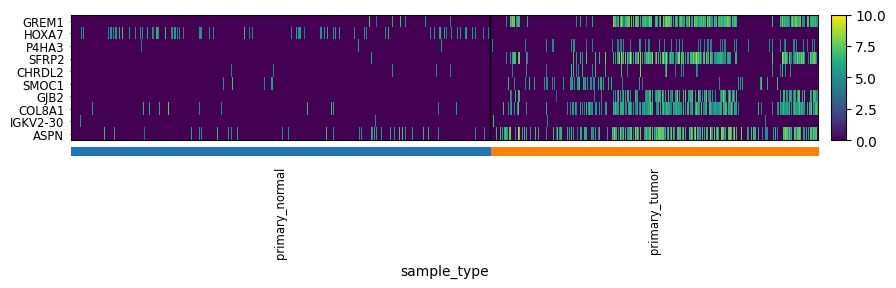

Fibroblasts_intestinal_early


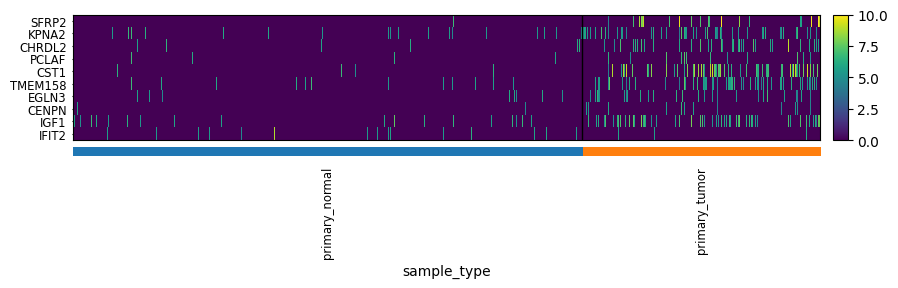

Mucous_cells_intestinal_advanced


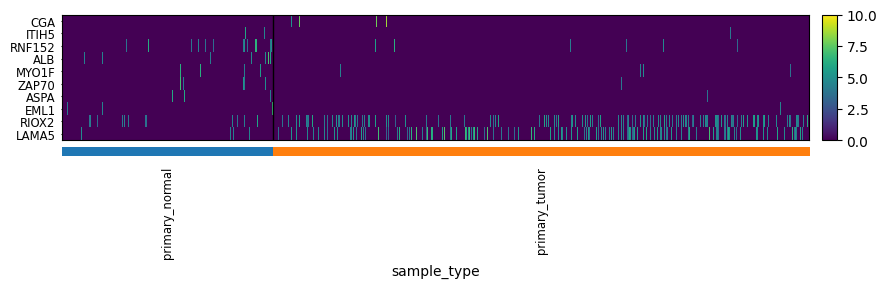

Mucous_cells_intestinal_early


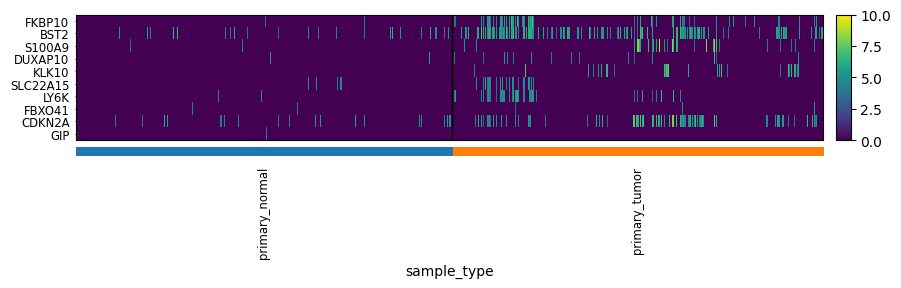

In [26]:
# heatmap of TOP10 DEGs for for fibroblasts and mucous cells of intestinal-type gastric cancer
get_heatmap(group_string='intestinal')

---

Fibroblasts_diffuse_advanced


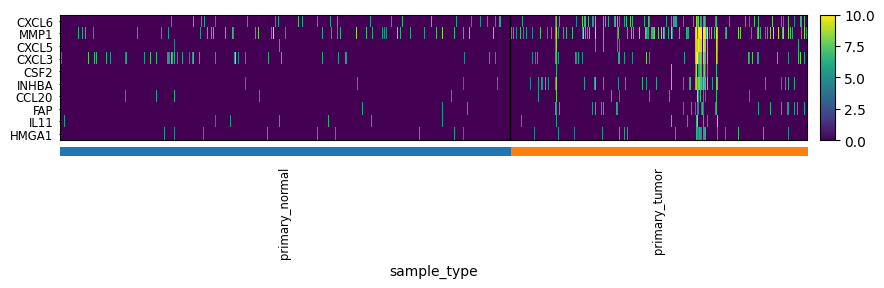

Fibroblasts_diffuse_early


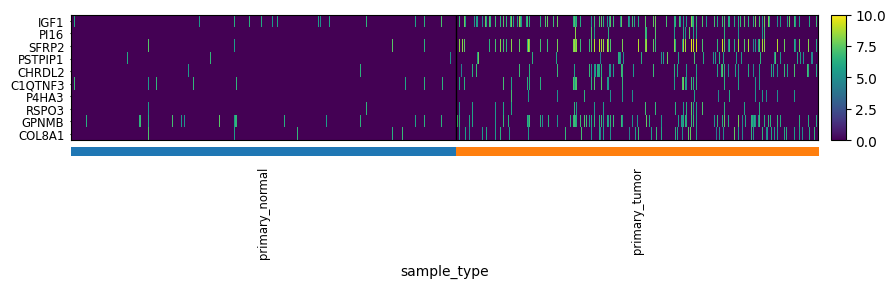

Mucous_cells_diffuse_advanced


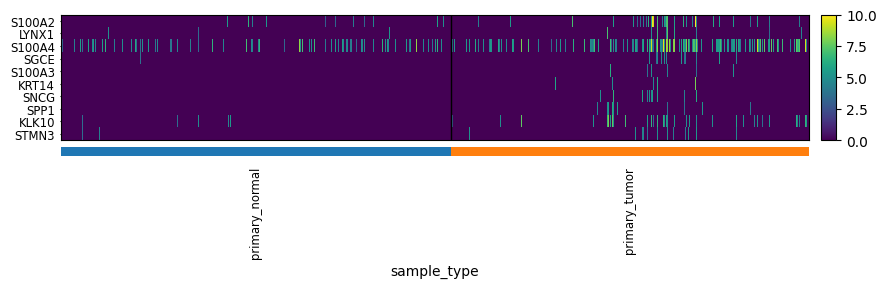

Mucous_cells_diffuse_early


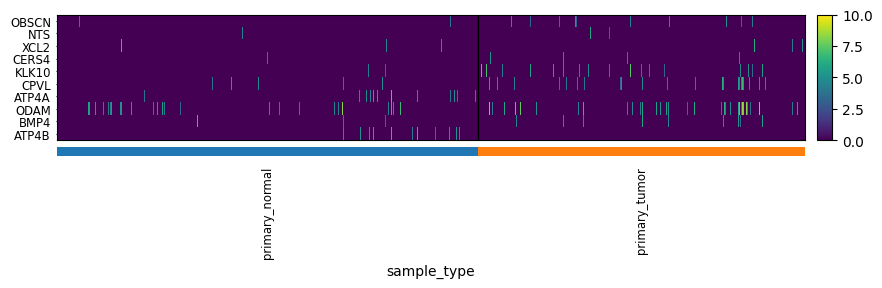

In [27]:
# get heatmaps of TOP10 DEGs for fibroblasts and mucous cells of diffuse-type gastric cancer
get_heatmap(group_string='diffuse')


Fibroblasts_mixed_advanced


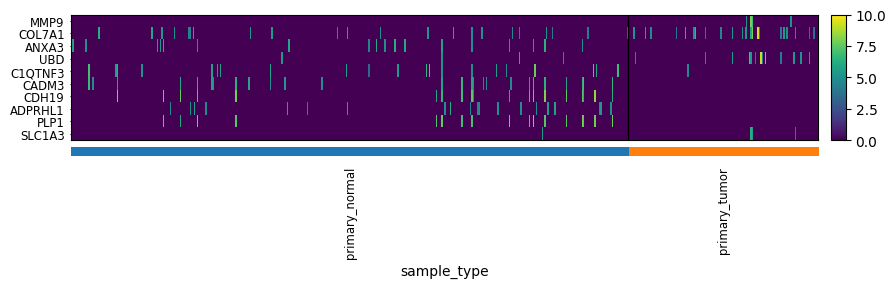

Mucous_cells_mixed_advanced


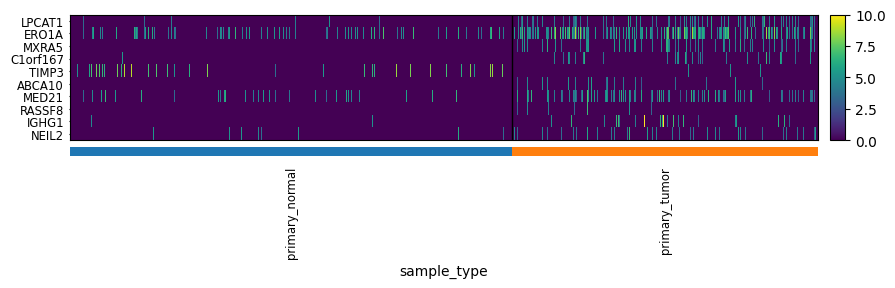

In [28]:
# get heatmaps of TOP10 DEGs for fibroblasts and mucous cells of mixed-type gastric cancer
get_heatmap(group_string='mixed')

In [136]:
def get_edger_dotplot(celltype, adata=adata, group_info_key='group_info',
                         comparison_group='comparison_group', n_top=10,
                         groupby=['sample_type', 'phase', 'lauren_class']):
    """
    Generates a dotplot of top DEGs for all comparison groups filtered by a string, grouped by multiple categories.

    Args:
    - celltype (str): String to filter comparison groups for celltype.
    - adata (AnnData): AnnData object containing DE results in .uns.
    - group_info_key (str): Key in adata.uns for comparison group information.
    - comparison_group (str): Column name in the group_info DataFrame for comparison group names.
    - n_top (int): Number of top DEGs to display per comparison group.
    - groupby (list of str): List of categories to group the dotplot by.

    The function concatenates top n DEGs from multiple comparison groups and removes duplicates before displaying.
    """

    print(celltype, ':')
    group_info = adata.uns[group_info_key]
    combined_genes = set()

    for comparison in group_info[group_info[comparison_group].str.contains(celltype)][comparison_group].unique():

        # extract TOP DEGs
        res = pd.DataFrame(adata.uns[f'edgeR_{comparison}'])
        res.index = res['names'].values
        top_genes = res.sort_values(by=['pvals_adj']).head(n_top).index
        combined_genes.update(top_genes)

    markers = list(combined_genes)

    sc.pl.dotplot(
    adata[adata.obs['celltype'] == celltype].copy(),
    markers,
    groupby=groupby,
    color_map='Blues',
    swap_axes=True,
    standard_scale='var',
    )


Fibroblasts :


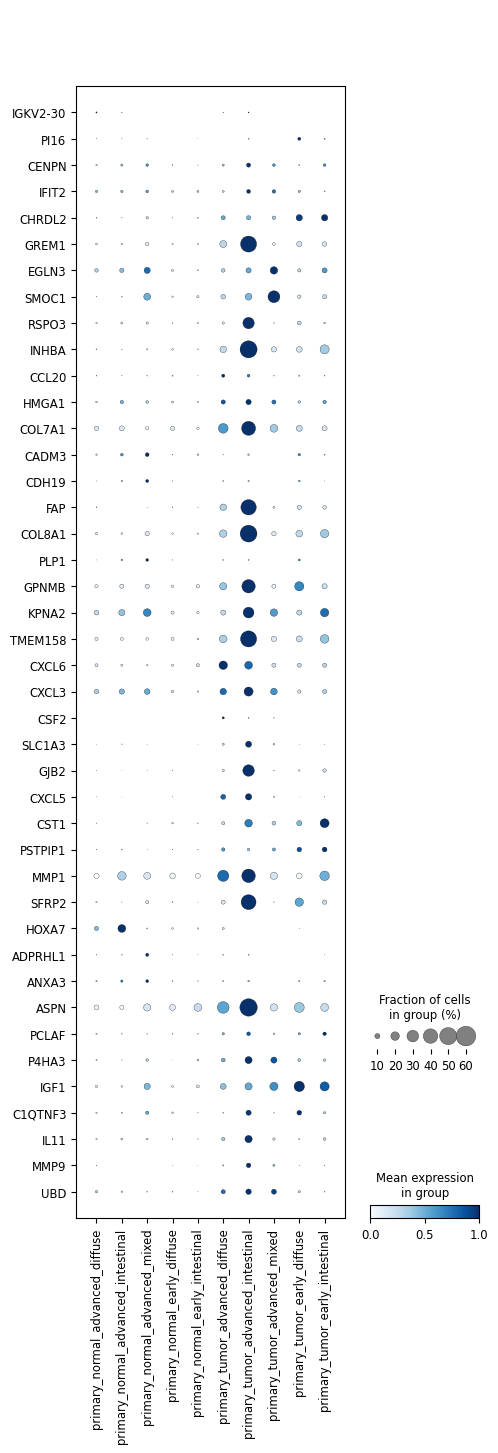

In [138]:
get_edger_dotplot(celltype='Fibroblasts')

Mucous_cells :


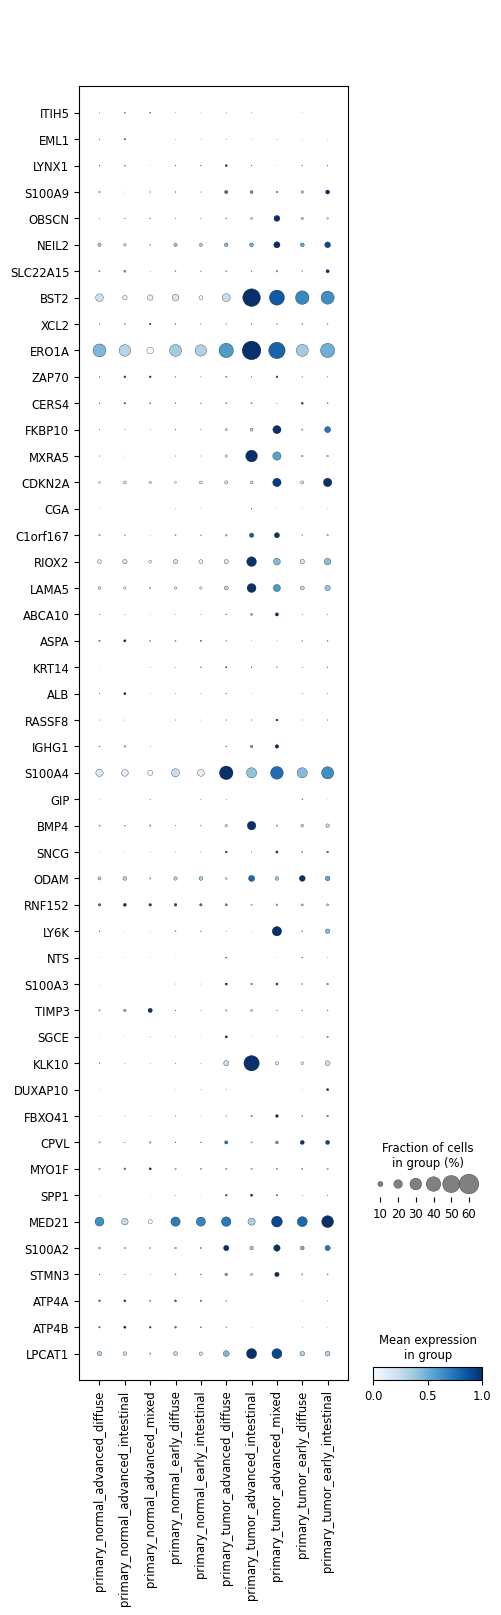

In [140]:
get_edger_dotplot(celltype='Mucous_cells')

### Single-cell specific method

The single-cell specific method in scVI's model.differential_expression()([Gayoso *et al.* 2022](http://doi.org/10.1038/s41587-021-01206-w)) uses a Bayesian variational autoencoder to model gene expression at the single-cell level, accounting for latent variables, batch effects, and technical noise, including dropout and zero inflation. This approach enables accurate identification of differentially expressed genes while maintaining cell-level resolution and handling the complexities of scRNA-seq data.

#### Differentially Expressed Genes (DEGs) between Tumor and Normal Samples - scVI


The scVI model was trained using the raw counts from the entire dataset, with batch effects and categorical covariates (e.g., dataset, patient) accounted for during data integration and model training. (see *NB1_integration.iypnb*)

In [ ]:
# set seed
scvi.settings.seed = 42

In [4]:
# load model
model_scvi = scvi.model.SCVI.load('/content/drive/MyDrive/model_scvi', adata=adata)
model_scvi

INFO     File /content/drive/MyDrive/model_scvi/model.pt already downloaded                                        


/usr/local/lib/python3.10/dist-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [6]:
# get DEGs and display TOP DEGs

n_top = 10
comparison_groups = adata.uns['group_info'].comparison_group.unique()
all_de_results_top = []
all_de_results = []

for comparison_group in comparison_groups:

    print(comparison_group, ':')
    # get DE results
    de_df = model_scvi.differential_expression(groupby='group', group1=f'{comparison_group}_tumor', group2=f'{comparison_group}_normal')

    # filter results
    de_df = de_df[de_df.lfc_mean.abs() > 0]
    de_df = de_df[de_df['bayes_factor'] > 1]
    de_df = de_df[de_df['non_zeros_proportion1'] > 0.1]

    # get top n results
    top_genes_df = de_df
    display(top_genes_df.head(n_top))

    # append dataframe
    top_genes_df['genes'] = top_genes_df.index
    top_genes_df['comparison_group'] = comparison_group
    all_de_results_top.append(top_genes_df.head(n_top))
    all_de_results.append(top_genes_df)


# concatenate all DataFrames into a single DataFrame
final_de_top_df = pd.concat(all_de_results_top, ignore_index=True)
final_de_df = pd.concat(all_de_results, ignore_index=True)


Fibroblasts_intestinal_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PGC,0.9836,0.0164,4.093937,0.000306,0.002692,0.0,0.25,-5.304253,-5.253325,3.502172,...,9.692190,32.967626,0.215926,0.914868,5.160480,41.605762,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
PGA3,0.9824,0.0176,4.022099,0.000404,0.005590,0.0,0.25,-6.238393,-6.404101,4.035871,...,3.366003,91.182254,0.255743,0.820144,3.719324,135.202423,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
LIPF,0.9798,0.0202,3.881665,0.000125,0.001843,0.0,0.25,-5.390613,-5.450170,3.433556,...,0.534456,22.185851,0.101072,0.776978,0.564518,34.001320,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
WNT2,0.9724,0.0276,3.561951,0.000073,0.000001,0.0,0.25,4.285792,4.248415,3.071879,...,0.761103,0.002398,0.303216,0.002398,0.632010,0.006089,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
SFRP2,0.9700,0.0300,3.476098,0.000420,0.000050,0.0,0.25,3.326832,3.562515,2.858476,...,5.122511,0.053957,0.416539,0.003597,4.868127,0.092239,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
VSTM2A,0.9690,0.0310,3.442277,0.000083,0.000340,0.0,0.25,-3.802611,-4.053119,3.598330,...,0.384380,1.519185,0.127106,0.381295,0.629466,2.885601,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
CST1,0.9682,0.0318,3.415972,0.000210,0.000014,0.0,0.25,3.446090,3.638208,2.394590,...,3.078101,0.000000,0.171516,0.000000,2.604629,0.000000,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
COL6A3,0.9642,0.0358,3.293351,0.002251,0.000167,0.0,0.25,3.255113,3.446333,2.133350,...,25.802450,0.868106,0.857580,0.340528,23.105330,1.463751,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
CXCL5,0.9642,0.0358,3.293351,0.000269,0.000013,0.0,0.25,3.544837,3.632076,2.651761,...,1.905054,0.001199,0.133231,0.001199,1.476490,0.004628,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal
MME,0.9634,0.0366,3.270420,0.000074,0.000009,0.0,0.25,2.892381,3.020851,2.247828,...,0.563553,0.022782,0.226646,0.021583,0.477874,0.029495,True,Fibroblasts_intestinal_advanced_tumor vs Fibro...,Fibroblasts_intestinal_advanced_tumor,Fibroblasts_intestinal_advanced_normal


Fibroblasts_diffuse_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PGA3,0.9616,0.0384,3.220541,0.000244,0.002040,0.0,0.25,-2.981479,-2.571459,3.733507,...,14.545821,15.334884,0.136959,0.525581,3.174990,33.108518,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
IGHA1,0.9612,0.0388,3.209762,0.000297,0.000393,0.0,0.25,-2.386823,-2.334965,4.524419,...,10.728097,2.475083,0.115811,0.134219,5.072159,2.949308,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
THBS2,0.9560,0.0440,3.078568,0.000151,0.000017,0.0,0.25,2.573610,2.699599,1.855398,...,0.682779,0.029236,0.210473,0.023920,1.393590,0.073308,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
CCN1,0.9534,0.0466,3.018434,0.000479,0.000179,0.0,0.25,2.256196,1.922028,3.934810,...,1.923464,0.451163,0.385700,0.178073,4.487731,1.458397,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
TFPI2,0.9520,0.0480,2.987364,0.000224,0.000045,0.0,0.25,2.306673,2.414914,1.980907,...,1.210473,0.074419,0.147029,0.043189,2.185516,0.258316,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
PTGDR2,0.9478,0.0522,2.899061,0.000066,0.000161,0.0,0.25,-1.911929,-1.975869,2.014080,...,0.405841,0.593355,0.176234,0.361462,0.693607,1.774043,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
IGLL5,0.9436,0.0564,2.817233,0.000625,0.000525,0.0,0.25,0.484953,0.410306,3.417744,...,7.466264,7.236545,0.434038,0.283721,15.813785,10.724314,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
GHRL,0.9390,0.0610,2.733941,0.000130,0.000342,0.0,0.25,-1.680067,-1.803910,2.071362,...,1.855992,0.121595,0.101712,0.103654,2.818523,0.402971,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
APOD,0.9388,0.0612,2.730455,0.000970,0.001589,0.0,0.25,-1.161639,-1.250735,2.741610,...,4.084592,6.959468,0.412890,0.629236,14.383534,24.805634,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal
MT-ATP8,0.9388,0.0612,2.730455,0.001312,0.001999,0.0,0.25,-1.846680,-1.547067,4.053371,...,10.858006,9.039867,0.319235,0.510299,15.718540,23.938277,True,Fibroblasts_diffuse_advanced_tumor vs Fibrobla...,Fibroblasts_diffuse_advanced_tumor,Fibroblasts_diffuse_advanced_normal


Fibroblasts_mixed_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
CRIP1,0.9546,0.0454,3.045780,0.001014,0.000328,0.0,0.25,1.604925,1.756205,0.845136,...,5.894737,1.356410,0.654135,0.407692,8.576480,2.559136,True,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
CDH13,0.9410,0.0590,2.769406,0.000104,0.000033,0.0,0.25,1.777071,1.803844,1.510946,...,0.691729,0.207692,0.248120,0.153846,0.734412,0.384205,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
EFEMP1,0.9344,0.0656,2.656329,0.000123,0.000341,0.0,0.25,-1.277071,-1.287819,2.236220,...,0.917293,1.948718,0.315789,0.415385,0.891643,3.258355,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
IGHA1,0.9344,0.0656,2.656329,0.000404,0.000412,0.0,0.25,0.321558,0.328165,3.271587,...,0.383459,0.894872,0.315789,0.148718,0.825191,0.804090,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
LINC00473,0.9278,0.0722,2.553376,0.000034,0.000044,0.0,0.25,0.214699,0.434685,1.619912,...,0.240602,0.164103,0.180451,0.120513,0.361523,0.273737,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
PTGIS,0.9272,0.0728,2.544453,0.000105,0.000066,0.0,0.25,1.096115,1.120410,2.478582,...,0.669173,0.420513,0.308271,0.207692,1.193160,0.835416,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
PAPPA2,0.9270,0.0730,2.541494,0.000076,0.000041,0.0,0.25,1.141404,1.120362,2.309156,...,0.398496,0.156410,0.218045,0.089744,0.919450,0.261419,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
NRG1,0.9270,0.0730,2.541494,0.000366,0.000233,0.0,0.25,1.256070,1.087718,2.552799,...,1.932331,1.276923,0.443609,0.374359,2.583765,2.519809,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
ENHO,0.9250,0.0750,2.512306,0.000146,0.000188,0.0,0.25,0.056382,-0.099514,2.817874,...,0.812030,0.771795,0.421053,0.353846,1.414228,1.655851,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal
ALKAL2,0.9242,0.0758,2.500830,0.000032,0.000027,0.0,0.25,0.781053,0.865234,2.408607,...,0.218045,0.182051,0.135338,0.135897,0.323713,0.290426,False,Fibroblasts_mixed_advanced_tumor vs Fibroblast...,Fibroblasts_mixed_advanced_tumor,Fibroblasts_mixed_advanced_normal


Fibroblasts_diffuse_early :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
C7,0.9414,0.0586,2.776633,0.000165,0.000056,0.0,0.25,0.937221,0.871398,2.931861,...,0.451697,0.035670,0.135770,0.018450,1.597412,0.145834,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
FBN2,0.9352,0.0648,2.669455,0.000039,0.000048,0.0,0.25,-0.740098,-0.654102,2.773829,...,0.180157,0.143911,0.109661,0.100861,0.459588,0.524922,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
SFRP2,0.9340,0.0660,2.649822,0.000562,0.000139,0.0,0.25,1.712469,1.625874,2.156704,...,1.955614,0.038130,0.194517,0.011070,5.579431,0.167044,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
CST1,0.9338,0.0662,2.646582,0.000231,0.000059,0.0,0.25,1.546417,1.713193,2.066184,...,1.027415,0.045510,0.101828,0.020910,2.043980,0.188710,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
LIPF,0.9306,0.0694,2.595943,0.000172,0.000564,0.0,0.25,-1.630196,-1.689085,1.575466,...,0.229765,2.033210,0.185379,0.416974,0.568860,6.002112,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
TPSAB1,0.9298,0.0702,2.583621,0.000540,0.000204,0.0,0.25,0.643893,0.526527,2.809257,...,1.593995,0.276753,0.144909,0.027060,4.588514,1.055382,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
ENHO,0.9286,0.0714,2.565380,0.000096,0.000207,0.0,0.25,-1.268551,-1.271519,2.369154,...,0.372063,0.530135,0.185379,0.318573,0.933253,2.280619,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
COL4A6,0.9268,0.0732,2.538542,0.000056,0.000104,0.0,0.25,-1.305758,-1.230160,2.485535,...,0.163185,0.218942,0.117493,0.172202,0.468014,0.902918,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
APOD,0.9266,0.0734,2.535598,0.001069,0.001327,0.0,0.25,-0.529006,-0.559324,2.469159,...,5.335509,3.367774,0.475196,0.576876,14.940292,16.153389,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal
WFDC1,0.9216,0.0784,2.464287,0.000048,0.000087,0.0,0.25,-1.206155,-1.194589,2.051380,...,0.195822,0.312423,0.135770,0.202952,0.552735,1.065678,False,Fibroblasts_diffuse_early_tumor vs Fibroblasts...,Fibroblasts_diffuse_early_tumor,Fibroblasts_diffuse_early_normal


Fibroblasts_intestinal_early :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PGC,0.9622,0.0378,3.236913,0.000198,0.001198,0.0,0.25,-2.940517,-3.094070,1.856009,...,0.178571,5.605007,0.113095,0.848401,0.644388,22.457403,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
SULF1,0.9550,0.0450,3.055049,0.000157,0.000022,0.0,0.25,2.411463,2.488521,1.650437,...,0.797619,0.054242,0.309524,0.045897,1.807081,0.229460,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
CST1,0.9472,0.0528,2.886999,0.000466,0.000053,0.0,0.25,2.218010,2.360872,2.380547,...,3.250000,0.011127,0.211310,0.008345,5.470955,0.038888,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
THBS2,0.9446,0.0554,2.836182,0.000063,0.000014,0.0,0.25,1.805203,1.928181,1.582829,...,0.202381,0.026426,0.163690,0.023644,0.505117,0.103763,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
F2RL2,0.9444,0.0556,2.832366,0.000079,0.000017,0.0,0.25,2.049884,2.178662,2.355427,...,0.383929,0.041725,0.238095,0.034771,0.884618,0.149786,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
CST4,0.9426,0.0574,2.798598,0.000245,0.000016,0.0,0.25,2.710457,2.461833,2.596016,...,1.785714,0.000000,0.157738,0.000000,2.761365,0.000000,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
SRSF9,0.9372,0.0628,2.702941,0.000077,0.000072,0.0,0.25,-0.243475,-0.586497,1.188541,...,0.270833,0.191933,0.223214,0.165508,0.731842,0.666493,True,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
SOD3,0.9362,0.0638,2.686076,0.000261,0.000363,0.0,0.25,-1.158661,-1.298927,2.198880,...,0.800595,0.739917,0.333333,0.403338,2.649956,3.344642,False,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
OLFM4,0.9356,0.0644,2.676074,0.000148,0.000028,0.0,0.25,1.656888,1.708010,2.014850,...,1.500000,0.029207,0.208333,0.025035,1.535546,0.103944,False,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal
CTHRC1,0.9354,0.0646,2.672760,0.000204,0.000054,0.0,0.25,1.739968,1.790573,1.657059,...,0.758929,0.089013,0.250000,0.062587,1.604969,0.242659,False,Fibroblasts_intestinal_early_tumor vs Fibrobla...,Fibroblasts_intestinal_early_tumor,Fibroblasts_intestinal_early_normal


Mucous_cells_intestinal_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
MMP7,0.9782,0.0218,3.803804,0.000259,9.013193e-06,0.0,0.25,4.578252,4.899791,3.320495,...,4.143531,0.075924,0.390877,0.017982,3.003054,0.057967,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
KLK7,0.9754,0.0246,3.680101,0.000093,2.426882e-06,0.0,0.25,4.323982,4.662729,2.908002,...,1.224931,0.000000,0.217853,0.000000,0.803014,0.000000,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
LRP8,0.9752,0.0248,3.671799,0.000022,1.799285e-06,0.0,0.25,3.635181,4.002930,2.292509,...,0.284310,0.000999,0.190326,0.000999,0.224931,0.004757,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
KRT7,0.9752,0.0248,3.671799,0.000369,5.303853e-05,0.0,0.25,2.759269,2.807826,1.727223,...,4.975226,0.140859,0.671648,0.098901,4.312547,0.155067,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
MATR3-1,0.9742,0.0258,3.631242,0.000012,6.452584e-07,0.0,0.25,4.491298,5.444425,3.213979,...,0.146284,0.000000,0.119544,0.000000,0.119415,0.000000,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
TFF2,0.9736,0.0264,3.607636,0.001837,1.140308e-02,0.0,0.25,-4.064565,-4.621839,3.396132,...,53.234762,159.484515,0.380653,0.819181,36.587585,135.485174,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
AHNAK2,0.9732,0.0268,3.592187,0.000101,6.173453e-06,0.0,0.25,3.798004,4.107471,2.508010,...,0.986237,0.014985,0.360204,0.013986,0.945804,0.025042,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
PRRG1,0.9728,0.0272,3.576961,0.000034,5.401762e-06,0.0,0.25,2.795843,3.165716,1.938249,...,0.318521,0.021978,0.221785,0.021978,0.299628,0.023108,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
SYT13,0.9720,0.0280,3.547151,0.000086,7.804036e-06,0.0,0.25,3.229976,3.614308,1.676802,...,1.055053,0.035964,0.451829,0.028971,0.895961,0.039990,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal
TNS4,0.9718,0.0282,3.539828,0.000077,8.639784e-06,0.0,0.25,3.032956,3.226168,2.028856,...,0.777821,0.030969,0.322061,0.027972,0.651317,0.037735,True,Mucous_cells_intestinal_advanced_tumor vs Muco...,Mucous_cells_intestinal_advanced_tumor,Mucous_cells_intestinal_advanced_normal


Mucous_cells_diffuse_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
A4GNT,0.9584,0.0416,3.137165,0.000036,0.000069,0.0,0.25,-0.788682,-0.866672,4.629704,...,0.272727,0.577787,0.139065,0.222774,0.332457,0.600814,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
GKN1,0.9564,0.0436,3.088119,0.003022,0.003436,0.0,0.25,-0.288859,-0.246535,4.436422,...,16.233968,22.027874,0.331689,0.435825,45.102890,47.756633,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
CLDN2,0.9512,0.0488,2.969994,0.000059,0.000027,0.0,0.25,0.787275,0.733999,3.995574,...,0.266150,0.155575,0.114400,0.066551,0.380553,0.171576,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
GKN2,0.9506,0.0494,2.957143,0.001422,0.001902,0.0,0.25,-0.248295,-0.180008,4.184291,...,6.875029,11.870787,0.432699,0.472774,16.166486,20.623658,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
OLFM4,0.9504,0.0496,2.952892,0.001049,0.000752,0.0,0.25,0.481638,0.475082,3.614074,...,7.924830,4.769015,0.360113,0.181936,9.887090,4.342429,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
CEACAM5,0.9502,0.0498,2.948657,0.000332,0.000164,0.0,0.25,1.364589,1.460572,3.238233,...,1.832746,0.739412,0.292459,0.151685,2.700251,1.247166,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
PGC,0.9486,0.0514,2.915349,0.013196,0.016805,0.0,0.25,-0.749531,-0.787417,3.439177,...,135.730327,217.966292,0.825934,0.934745,183.802069,249.870818,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
PGA3,0.9486,0.0514,2.915349,0.001130,0.001459,0.0,0.25,-0.538094,-0.464388,4.406923,...,11.534414,8.938850,0.141649,0.159032,9.363803,21.992726,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
AREG,0.9466,0.0534,2.875066,0.000107,0.000126,0.0,0.25,0.567143,0.721580,4.099981,...,0.405685,0.550130,0.138360,0.157087,0.810518,1.258359,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal
MMP7,0.9464,0.0536,2.871116,0.000174,0.000036,0.0,0.25,1.536680,1.401841,3.203134,...,2.635424,0.436041,0.233968,0.106309,2.272767,0.365679,True,Mucous_cells_diffuse_advanced_tumor vs Mucous_...,Mucous_cells_diffuse_advanced_tumor,Mucous_cells_diffuse_advanced_normal


Mucous_cells_mixed_advanced :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
GSTA1,0.9636,0.0364,3.276107,0.000049,0.000520,0.0,0.25,-2.916778,-2.913809,2.047889,...,0.179340,3.658077,0.107604,0.532210,0.169527,6.518848,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
IFI6,0.9616,0.0384,3.220541,0.000232,0.000040,0.0,0.25,2.518903,2.588247,1.886834,...,4.282640,0.296333,0.476327,0.104063,2.978734,0.308946,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
LGALS1,0.9592,0.0408,3.157417,0.000176,0.000032,0.0,0.25,2.610295,2.671427,2.097763,...,0.350072,0.074331,0.127690,0.038652,0.215870,0.178997,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
FABP1,0.9590,0.0410,3.152319,0.000534,0.004878,0.0,0.25,-2.601593,-2.755235,2.959755,...,6.190818,31.436075,0.239598,0.649158,5.011957,48.187480,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
UBD,0.9546,0.0454,3.045780,0.000272,0.000022,0.0,0.25,2.956885,2.869624,2.250337,...,6.068867,0.078295,0.328551,0.012884,2.644645,0.050326,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
KRT20,0.9536,0.0464,3.022945,0.000393,0.001726,0.0,0.25,-2.120944,-2.224800,2.374044,...,2.094692,7.765114,0.281205,0.640238,2.175779,14.996705,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
SLC39A5,0.9536,0.0464,3.022945,0.000040,0.000141,0.0,0.25,-1.894624,-2.040593,1.820888,...,0.387374,0.712587,0.173601,0.323092,0.323469,1.223242,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
PCSK5,0.9530,0.0470,3.009467,0.000034,0.000165,0.0,0.25,-1.947466,-2.186131,2.738714,...,0.200861,0.589693,0.150646,0.330030,0.454814,1.975903,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
ANGPTL4,0.9530,0.0470,3.009467,0.000179,0.000405,0.0,0.25,-1.520168,-1.660224,3.110196,...,0.704448,0.997027,0.252511,0.325074,1.410883,3.633667,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal
CLDN3,0.9526,0.0474,3.000573,0.000272,0.000846,0.0,0.25,-1.484047,-1.687895,2.342172,...,3.007174,3.342914,0.395983,0.624381,1.862519,7.123306,True,Mucous_cells_mixed_advanced_tumor vs Mucous_ce...,Mucous_cells_mixed_advanced_tumor,Mucous_cells_mixed_advanced_normal


Mucous_cells_intestinal_early :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
REG4,0.9598,0.0402,3.172858,0.002130,0.000759,0.0,0.25,2.258898,2.561541,3.419113,...,40.465716,3.667437,0.578238,0.244123,23.782268,6.417123,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
LIPF,0.9592,0.0408,3.157417,0.001648,0.003879,0.0,0.25,-1.225249,-1.390282,4.385360,...,6.345185,42.378227,0.177183,0.456647,7.060363,48.716105,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
A4GNT,0.9576,0.0424,3.117282,0.000037,0.000048,0.0,0.25,-0.792164,-0.830139,4.690888,...,0.274663,0.372254,0.124634,0.200578,0.310502,0.422518,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
DPP4,0.9542,0.0458,3.036589,0.000030,0.000046,0.0,0.25,0.607089,0.996916,3.766412,...,0.255323,0.160501,0.142411,0.090173,0.240061,0.395628,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
PGC,0.9540,0.0460,3.032022,0.010012,0.014171,0.0,0.25,-1.524488,-1.652645,3.996665,...,134.921469,195.730250,0.631373,0.748170,146.475793,217.723657,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
LTF,0.9520,0.0480,2.987364,0.000559,0.001794,0.0,0.25,-1.408722,-1.420650,4.023771,...,3.743700,14.989017,0.210393,0.511946,3.978158,17.729746,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
GKN2,0.9518,0.0482,2.982996,0.000817,0.000939,0.0,0.25,-1.014686,-1.107415,4.099790,...,6.229146,4.678420,0.247900,0.291137,9.504267,9.079943,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
GKN1,0.9514,0.0486,2.974311,0.001353,0.001618,0.0,0.25,-1.283727,-1.384416,4.121004,...,7.688220,8.139884,0.209221,0.265896,17.597534,20.160033,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
MT1A,0.9502,0.0498,2.948657,0.000049,0.000168,0.0,0.25,-0.210556,0.212204,3.314088,...,0.391287,0.494605,0.154327,0.138150,0.310759,1.023781,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal
MSMB,0.9486,0.0514,2.915349,0.001415,0.001331,0.0,0.25,-1.134306,-1.329988,3.328474,...,13.639773,13.707129,0.389139,0.527938,15.762974,17.361119,True,Mucous_cells_intestinal_early_tumor vs Mucous_...,Mucous_cells_intestinal_early_tumor,Mucous_cells_intestinal_early_normal


Mucous_cells_diffuse_early :


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
GCG,0.9578,0.0422,3.122219,0.000092,0.000019,0.0,0.25,2.393771,2.593397,3.206313,...,0.327273,0.071298,0.124633,0.002278,0.360622,0.033349,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
LIPF,0.9578,0.0422,3.122219,0.002533,0.002812,0.0,0.25,-0.345520,-0.389826,4.128989,...,18.296188,16.787244,0.312903,0.287016,24.993657,21.931010,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
LTF,0.9564,0.0436,3.088119,0.001029,0.002527,0.0,0.25,-1.185811,-1.287193,4.183269,...,5.957771,15.382005,0.289443,0.599089,8.399419,24.286010,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
A4GNT,0.9522,0.0478,2.991749,0.000045,0.000050,0.0,0.25,-0.595392,-0.581256,4.426465,...,0.308504,0.341686,0.157185,0.215262,0.384863,0.448994,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
REG3A,0.9512,0.0488,2.969994,0.006116,0.009751,0.0,0.25,-0.734478,-0.770137,3.558191,...,59.007331,83.892483,0.488270,0.733713,82.092854,132.823544,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
SPINK4,0.9510,0.0490,2.965694,0.000318,0.000224,0.0,0.25,1.734740,1.954377,3.135264,...,3.212903,2.026196,0.123754,0.048064,4.943068,2.949700,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
REG4,0.9506,0.0494,2.957143,0.000908,0.000532,0.0,0.25,2.061665,2.307896,3.330135,...,10.891789,6.404784,0.432551,0.194305,8.822041,5.742608,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
PRR4,0.9506,0.0494,2.957143,0.000373,0.000401,0.0,0.25,-0.486691,-0.550650,4.313951,...,3.136657,2.174943,0.212610,0.265831,4.484513,3.766044,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
PGC,0.9506,0.0494,2.957143,0.013442,0.022566,0.0,0.25,-1.309831,-1.438422,3.850052,...,140.190029,238.039636,0.647801,0.849658,189.552149,344.835045,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal
AREG,0.9490,0.0510,2.923583,0.000030,0.000015,0.0,0.25,1.716907,1.787193,3.178100,...,0.278006,0.087699,0.125220,0.038497,0.225749,0.090921,True,Mucous_cells_diffuse_early_tumor vs Mucous_cel...,Mucous_cells_diffuse_early_tumor,Mucous_cells_diffuse_early_normal


In [7]:
def get_scvi_dotplot(celltype, adata=adata, de_df=final_de_top_df, comparison_group='comparison_group',
                     groupby=['sample_type', 'phase', 'lauren_class']):
    """
    Generates a dotplot of top differentially expressed genes (DEGs) for a specific cell type across
    multiple comparison groups.

    Args:
    - celltype (str): The name of the cell type to filter the AnnData object and DEGs for.
    - adata (AnnData): AnnData object containing single-cell RNA-seq data and metadata.
    - de_df (DataFrame): DataFrame containing DE results, including gene names and comparison group information.
    - comparison_group (str): Column name in the de_df DataFrame that specifies comparison groups (e.g., cell types, conditions).
    - groupby (list of str): List of categorical observation fields to group the dotplot (e.g., sample type, phase, lauren class).

    The function concatenates top n DEGs from multiple comparison groups and removes duplicates before displaying.
    """

    print(celltype, ':')

    celltype_de_df = de_df[de_df[comparison_group].str.contains(celltype)]
    markers = list(set(celltype_de_df['genes'].tolist()))


    sc.pl.dotplot(
        adata[adata.obs['celltype'] == celltype].copy(),
        markers,
        groupby=groupby,
        color_map='Blues',
        swap_axes=True,
        standard_scale='var',
        )


Fibroblasts :


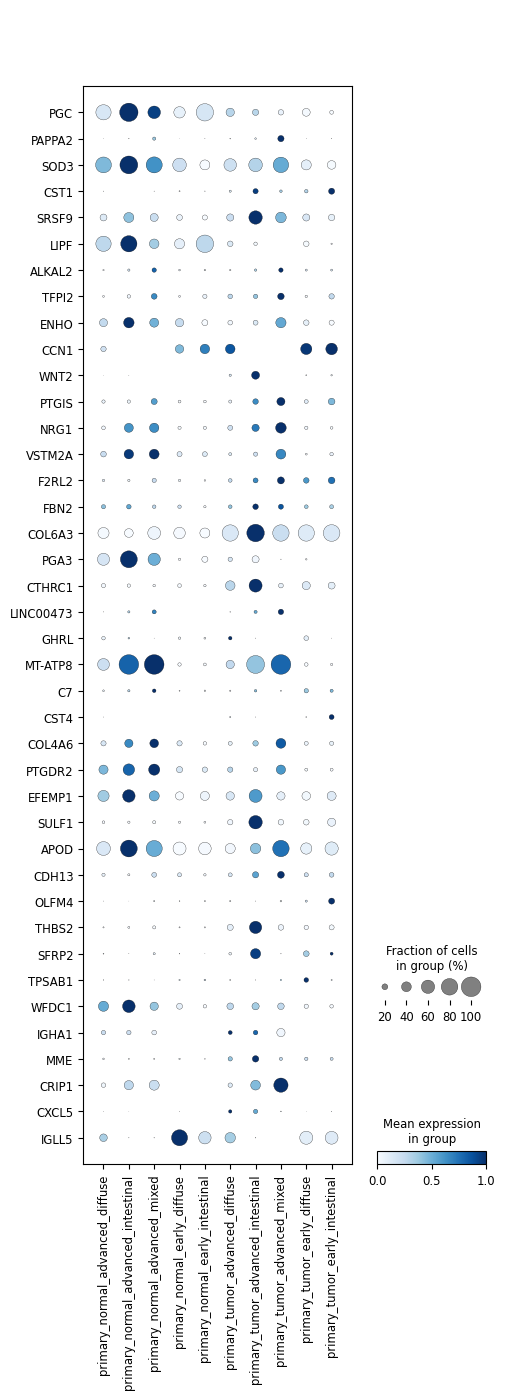

In [8]:
# TOP10 DEGs (for each comparison group) - Fibroblasts
get_scvi_dotplot(celltype='Fibroblasts')

Mucous_cells :


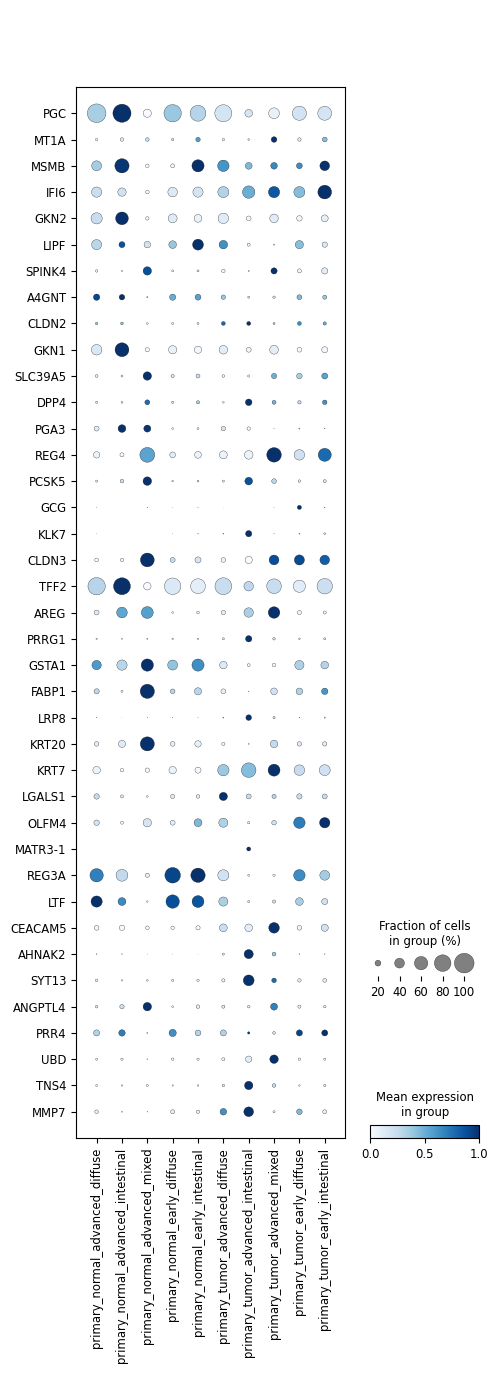

In [10]:
# TOP10 DEGs (for each comparison group) - Mucous cells
get_scvi_dotplot(celltype='Mucous_cells')

### Intersections of Differential Expression Results between Single-cell-specific and Pseudobulk Methods

In [11]:
def get_edger_degs(celltype, adata=adata, group_info_key = 'group_info',
                   comaprison_group='comparison_group', logfc=1.5, pval=0.001):

  """
    Extracts differentially expressed genes (DEGs) from EdgeR results for a specific cell type
    based on a log fold change and p-value threshold.

    Args:
    - celltype (str): Cell type string to filter the comparison groups.
    - adata (AnnData): AnnData object containing DE results.
    - group_info_key (str): Key in adata.uns for accessing group information.
    - comaprison_group (str): Column name for comparison group in group_info.
    - logfc (float): Minimum absolute log2 fold change threshold for DEGs.
    - pval (float): Maximum p-value threshold for DEGs.

    Returns:
    - List of unique DEGs for the specified cell type that meet the given thresholds.
  """

  combined_degs = set()
  group_info = adata.uns[group_info_key]

  for comparison in group_info[group_info[comaprison_group].str.contains(celltype)][comaprison_group].unique():

    # extract DEGs with absolute log fold change > logfc and p-value < pval
    res = pd.DataFrame(adata.uns[f'edgeR_{comparison}'])
    degs = res[(res['logfoldchanges'].abs() > logfc) & (res['pvals'] < pval)]['names'].tolist()
    combined_degs.update(degs)

  return list(combined_degs)



In [66]:
def get_scvi_degs(celltype, de_df=final_de_df, comaprison_group='comparison_group',
                  lfc_mean=1.5, bayes_factor=1, non_zeros_proportion1=0.5):
    """
    Extracts differentially expressed genes (DEGs) from scVI results for a specific cell type
    based on thresholds for mean log fold change, Bayes factor, and non-zero proportions.

    Args:
    - celltype (str): Cell type string to filter the comparison groups.
    - de_df (DataFrame): DataFrame containing scVI differential expression results.
    - comaprison_group (str): Column name for comparison group in de_df.
    - lfc_mean (float): Minimum absolute mean log fold change threshold for DEGs.
    - bayes_factor (float): Minimum Bayes factor threshold for DEGs
        (> 1: Evidence,  > 3: Strong evidence, > 10: Very strong evidence in favor of differential expression)
    - non_zeros_proportion1 (float): Minimum proportion of non-zero expressing cells in group1.

    Returns:
    - List of unique DEGs for the specified cell type that meet the given thresholds.

    """


    celltype_de_df = de_df[de_df['comparison_group'].str.contains(celltype)]
    celltype_de_df = celltype_de_df[celltype_de_df.lfc_mean.abs() > lfc_mean]
    celltype_de_df = celltype_de_df[celltype_de_df['bayes_factor'] > bayes_factor]
    celltype_de_df = celltype_de_df[celltype_de_df['non_zeros_proportion1'] >= non_zeros_proportion1]


    combined_degs = list(set(celltype_de_df['genes'].tolist()))

    return combined_degs

Overlapping differentially expressed genes (DEGs) from both pseudobulk and single-cell analyses were identified. In the pseudobulk analysis, DEGs were selected based on an absolute log2 fold change of at least 1.5 and an edgeR p-value < 0.001. In the single-cell specific analysis using scVI, we considered DEGs with strong evidence and expressed in at least half of the cancerous cells. This approach ensures the identification of genes consistently expressed across tumor-associated cell populations.

**Overlapping DEGs - Fibroblasts:**


In [51]:
# get DEGs from edgeR DEA - Fibroblasts
edger_fibroblasts = get_edger_degs(celltype='Fibroblasts')
print('Number of DEGs - edgeR:', len(edger_fibroblasts))

Number of DEGs - edgeR: 180


In [67]:
# get DEGs from scVI DEA - Fibroblasts
scvi_fibroblasts = get_scvi_degs(celltype='Fibroblasts')
print('Number of DEGs - scVI:', len(scvi_fibroblasts))

Number of DEGs - scVI: 55


In [68]:
# overlapping DEGs - Fibroblasts
deg_overlap_fibroblasts = [gene for gene in edger_fibroblasts if gene in scvi_fibroblasts]
print('Number of overlapping DEGs - scVI:', len(deg_overlap_fibroblasts))

Number of overlapping DEGs - scVI: 6


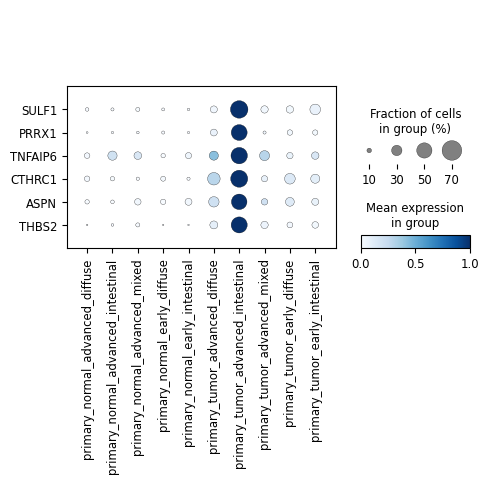

In [69]:
# plot overlapping DEGs - Fibroblasts
sc.pl.dotplot(
    adata[adata.obs['celltype'] == 'Fibroblasts'].copy(),
    deg_overlap_fibroblasts,
    groupby=['sample_type', 'phase', 'lauren_class'],
    color_map='Blues',
    swap_axes=True,
    standard_scale='var',
    )

For advanced intestinal tumor samples, the gene expression profile for fibroblasts shows a distinct pattern where certain genes, such as SULF1, PRRX1, and ASPN, appear to be more prominently expressed compared to other groups. This suggests that fibroblasts in advanced intestinal tumors have a unique gene expression signature, potentially contributing to the tumor microenvironment and disease progression.

For instance, SULF1, PRRX1, and ASPN are highly relevant to the role of fibroblasts in gastric cancer. SULF1 is overexpressed in cancer-associated fibroblasts (CAFs) within gastric tumors, where it aids in tumor growth, metastasis, and chemotherapy resistance by modulating signaling pathways, such as TGF-β ([Hur et al., 2021](https://doi.org/10.1002/path.4055); [Fang et al., 2024](https://doi.org/10.1038/s41420-024-01882-y)). PRRX1, a master transcription factor, drives fibroblasts toward a myofibroblastic phenotype, enhancing the aggressiveness and progression of gastric cancer ([Lee et al., 2022](https://doi.org/10.1038/s41467-022-30484-4)). ASPN, commonly found in CAFs, promotes collagen production and fibroblast migration, which facilitates tumor cell invasion and supports a fibrotic environment conducive to cancer advancement ([Tanaka, 2022](https://doi.org/10.1111/pin.13211); [Dong et al., 2022](https://doi.org/10.3389/fbioe.2022.1025546)).

**Overlapping DEGs - Mucous cells:**

In [28]:
# get DEGs from edgeR DEA - Mucous cells
edger_mucous_cells = get_edger_degs(celltype='Mucous_cells')
print('Number of DEGs - edgeR:', len(edger_mucous_cells))

Number of DEGs - edgeR: 540


In [70]:
# get DEGs from scVI DEA - Mucous cells
scvi_mucous_cells = get_scvi_degs(celltype='Mucous_cells')
print('Number of DEGs - scVI:', len(scvi_mucous_cells))

Number of DEGs - scVI: 97


In [71]:
# overlapping DEGs - Mucous cells
deg_overlap_mucous_cells = [gene for gene in edger_mucous_cells if gene in scvi_mucous_cells]
print('Number of overlapping DEGs - scVI:', len(deg_overlap_mucous_cells))

Number of overlapping DEGs - scVI: 9


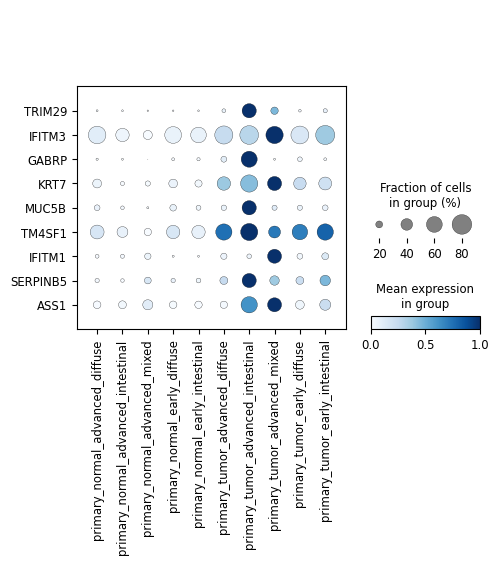

In [72]:
# plot overlapping DEGs - Mucous cells
sc.pl.dotplot(
    adata[adata.obs['celltype'] == 'Mucous_cells'].copy(),
    deg_overlap_mucous_cells,
    groupby=['sample_type', 'phase', 'lauren_class'],
    color_map='Blues',
    swap_axes=True,
    standard_scale='var',
    )

Early detection is crucial in improving outcomes for gastric cancer, as it is often diagnosed at advanced stages, leading to high mortality rates ([Hu et al., 2021](https://doi.org/10.2147/IJGM.S321265); [Fang et al., 2024](https://doi.org/10.1038/s41420-024-01882-y)). Identifying early markers could significantly aid in timely diagnosis and intervention. The figure illustrates that TM4SF1 is expressed in all early tumor samples, suggesting its potential as an early marker for gastric cancer. TM4SF1 is part of the tetraspanin family and has been implicated in promoting cell proliferation, migration, and invasion in various cancers, including gastric cancer ([Rahim et al., 2023](https://doi.org/10.3390/ph16010110); [Wei et al., 2022](https://doi.org/10.1016/j.mrfmmm.2022.111802)). Its consistent expression in early-stage tumors highlights its relevance as a biomarker and a possible target for early therapeutic intervention.

---

In [154]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
anndata                          0.10.8
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_api_compat                 1.8
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.16.0.32.21
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                    

In [156]:
%%R
installed.packages()[, c("Package", "Version")]

              Package         Version   
BiocManager   "BiocManager"   "1.30.25" 
BiocVersion   "BiocVersion"   "3.19.1"  
edgeR         "edgeR"         "4.2.1"   
IRdisplay     "IRdisplay"     "1.1"     
IRkernel      "IRkernel"      "1.3.2"   
limma         "limma"         "3.60.4"  
locfit        "locfit"        "1.5-9.10"
pbdZMQ        "pbdZMQ"        "0.3-13"  
repr          "repr"          "1.1.7"   
statmod       "statmod"       "1.5.0"   
askpass       "askpass"       "1.2.0"   
backports     "backports"     "1.5.0"   
base64enc     "base64enc"     "0.1-3"   
bit           "bit"           "4.0.5"   
bit64         "bit64"         "4.0.5"   
blob          "blob"          "1.2.4"   
boot          "boot"          "1.3-31"  
brew          "brew"          "1.0-10"  
brio          "brio"          "1.1.5"   
broom         "broom"         "1.0.6"   
bslib         "bslib"         "0.8.0"   
cachem        "cachem"        "1.1.0"   
callr         "callr"         "3.7.6"   
cellranger    "c